# P-219 => Hourly Energy Consumption Forecast

    The hourly power consumption data comes from PJM's website and are in megawatts (MW).

    ● Build model, split the last year into a test set and train model on remaining data.
    ● Forecast for next 30 days using model build.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [70]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 200
sns.set_style('darkgrid')

In [71]:
# Importing data set
df = pd.read_excel(r"C:\Users\rohit\Downloads\Project\PJMW_MW_Hourly.xlsx", index_col=0, parse_dates=True)
df['Years'] = df.index.year
s = (df.index.month * 100 + df.index.day - 320) % 1300
df['Season'] = pd.cut(s, [0, 300, 600, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
df['Hours'] = df.index.hour
df

PJMW_MW  Years  Season  Hours
Datetime                                          
2002-12-31 01:00:00   5077.0   2002  Winter      1
2002-12-31 02:00:00   4939.0   2002  Winter      2
2002-12-31 03:00:00   4885.0   2002  Winter      3
2002-12-31 04:00:00   4857.0   2002  Winter      4
2002-12-31 05:00:00   4930.0   2002  Winter      5
...                      ...    ...     ...    ...
2018-01-01 20:00:00   8401.0   2018  Winter     20
2018-01-01 21:00:00   8373.0   2018  Winter     21
2018-01-01 22:00:00   8238.0   2018  Winter     22
2018-01-01 23:00:00   7958.0   2018  Winter     23
2018-01-02 00:00:00   7691.0   2018  Winter      0

[143206 rows x 4 columns]

## Data preprocessing and EDA

In [72]:
df['Season'].fillna('Summer', inplace= True)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   PJMW_MW  143206 non-null  float64 
 1   Years    143206 non-null  int64   
 2   Season   143206 non-null  category
 3   Hours    143206 non-null  int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 4.5 MB


In [74]:
df.describe(include='all')

PJMW_MW          Years  Season          Hours
count   143206.000000  143206.000000  143206  143206.000000
unique            NaN            NaN       4            NaN
top               NaN            NaN  Spring            NaN
freq              NaN            NaN   37266            NaN
mean      5602.375089    2009.918691     NaN      11.501620
std        979.142872       4.730344     NaN       6.921789
min        487.000000    2002.000000     NaN       0.000000
25%       4907.000000    2006.000000     NaN       6.000000
50%       5530.000000    2010.000000     NaN      12.000000
75%       6252.000000    2014.000000     NaN      18.000000
max       9594.000000    2018.000000     NaN      23.000000

In [75]:
df.isna().sum()

PJMW_MW    0
Years      0
Season     0
Hours      0
dtype: int64

In [76]:
# IQR
Q1 = np.percentile(df['PJMW_MW'], 25, interpolation='midpoint')
Q3 = np.percentile(df['PJMW_MW'], 75, interpolation='midpoint')

IQR = Q3 - Q1
print('Q1 : ', Q1)
print('Q3 : ', Q3)
print('IQR :', IQR)

Q1 :  4907.0
Q3 :  6252.0
IQR : 1345.0


In [77]:
out_low = df[df['PJMW_MW'] < (Q1 - 1.5*IQR)]
out_low

PJMW_MW  Years  Season  Hours
Datetime                                          
2003-05-29 00:00:00    487.0   2003  Spring      0
2012-04-01 13:00:00   2878.0   2012  Spring     13
2012-04-01 14:00:00   2721.0   2012  Spring     14
2012-04-01 15:00:00   2663.0   2012  Spring     15
2012-04-01 16:00:00   2574.0   2012  Spring     16
2012-04-01 17:00:00   2586.0   2012  Spring     17
2012-04-01 18:00:00   2600.0   2012  Spring     18
2012-04-01 19:00:00   2630.0   2012  Spring     19
2012-04-01 23:00:00   2690.0   2012  Spring     23
2012-04-02 00:00:00   2553.0   2012  Spring      0

In [78]:
ol = out_low['PJMW_MW'].values
ol = list(ol)
ol

[487.0, 2878.0, 2721.0, 2663.0, 2574.0, 2586.0, 2600.0, 2630.0, 2690.0, 2553.0]

In [79]:
out_high = df[df['PJMW_MW'] > (Q3 + 1.5*IQR)]
out_high

PJMW_MW  Years  Season  Hours
Datetime                                          
2002-07-29 18:00:00   8270.0   2002  Summer     18
2002-07-22 17:00:00   8300.0   2002  Summer     17
2003-01-23 18:00:00   8296.0   2003  Winter     18
2003-01-23 19:00:00   8431.0   2003  Winter     19
2003-01-23 20:00:00   8437.0   2003  Winter     20
...                      ...    ...     ...    ...
2018-01-02 21:00:00   8563.0   2018  Winter     21
2018-01-02 22:00:00   8322.0   2018  Winter     22
2018-01-01 19:00:00   8328.0   2018  Winter     19
2018-01-01 20:00:00   8401.0   2018  Winter     20
2018-01-01 21:00:00   8373.0   2018  Winter     21

[693 rows x 4 columns]

In [80]:
oh = out_high['PJMW_MW'].values
oh = list(oh)
oh

[8270.0,
 8300.0,
 8296.0,
 8431.0,
 8437.0,
 8333.0,
 8417.0,
 8478.0,
 8366.0,
 8297.0,
 8307.0,
 8598.0,
 8574.0,
 8490.0,
 8289.0,
 8409.0,
 8279.0,
 8362.0,
 8298.0,
 8289.0,
 8321.0,
 8322.0,
 8280.0,
 8336.0,
 8361.0,
 8391.0,
 8300.0,
 8395.0,
 8608.0,
 8719.0,
 8566.0,
 8547.0,
 8546.0,
 8505.0,
 8299.0,
 8330.0,
 8498.0,
 8546.0,
 8546.0,
 8444.0,
 8294.0,
 8376.0,
 8411.0,
 8301.0,
 8569.0,
 8516.0,
 8550.0,
 8605.0,
 8546.0,
 8470.0,
 8320.0,
 8402.0,
 8393.0,
 8480.0,
 8595.0,
 8564.0,
 8566.0,
 8298.0,
 8327.0,
 8515.0,
 8625.0,
 8707.0,
 8656.0,
 8493.0,
 8274.0,
 8277.0,
 8352.0,
 8347.0,
 8278.0,
 8308.0,
 8403.0,
 8392.0,
 8589.0,
 8721.0,
 8823.0,
 8797.0,
 8695.0,
 8356.0,
 8498.0,
 8664.0,
 8623.0,
 8340.0,
 8404.0,
 8400.0,
 8319.0,
 8287.0,
 8383.0,
 8381.0,
 8304.0,
 8338.0,
 8435.0,
 8501.0,
 8523.0,
 8316.0,
 8317.0,
 8424.0,
 8310.0,
 8275.0,
 8352.0,
 8485.0,
 8536.0,
 8589.0,
 8465.0,
 8485.0,
 8382.0,
 8453.0,
 8294.0,
 8324.0,
 8278.0,
 8488.0,
 8742.0,
 

In [81]:
outliers = ol + oh
outliers

[487.0,
 2878.0,
 2721.0,
 2663.0,
 2574.0,
 2586.0,
 2600.0,
 2630.0,
 2690.0,
 2553.0,
 8270.0,
 8300.0,
 8296.0,
 8431.0,
 8437.0,
 8333.0,
 8417.0,
 8478.0,
 8366.0,
 8297.0,
 8307.0,
 8598.0,
 8574.0,
 8490.0,
 8289.0,
 8409.0,
 8279.0,
 8362.0,
 8298.0,
 8289.0,
 8321.0,
 8322.0,
 8280.0,
 8336.0,
 8361.0,
 8391.0,
 8300.0,
 8395.0,
 8608.0,
 8719.0,
 8566.0,
 8547.0,
 8546.0,
 8505.0,
 8299.0,
 8330.0,
 8498.0,
 8546.0,
 8546.0,
 8444.0,
 8294.0,
 8376.0,
 8411.0,
 8301.0,
 8569.0,
 8516.0,
 8550.0,
 8605.0,
 8546.0,
 8470.0,
 8320.0,
 8402.0,
 8393.0,
 8480.0,
 8595.0,
 8564.0,
 8566.0,
 8298.0,
 8327.0,
 8515.0,
 8625.0,
 8707.0,
 8656.0,
 8493.0,
 8274.0,
 8277.0,
 8352.0,
 8347.0,
 8278.0,
 8308.0,
 8403.0,
 8392.0,
 8589.0,
 8721.0,
 8823.0,
 8797.0,
 8695.0,
 8356.0,
 8498.0,
 8664.0,
 8623.0,
 8340.0,
 8404.0,
 8400.0,
 8319.0,
 8287.0,
 8383.0,
 8381.0,
 8304.0,
 8338.0,
 8435.0,
 8501.0,
 8523.0,
 8316.0,
 8317.0,
 8424.0,
 8310.0,
 8275.0,
 8352.0,
 8485.0,
 8536.0,
 8

In [82]:
df['PJMW_MW'] = df['PJMW_MW'].replace(to_replace=outliers, value=5602.375089)

In [83]:
df.describe()

PJMW_MW          Years          Hours
count  143206.000000  143206.000000  143206.000000
mean     5588.316737    2009.918691      11.501620
std       956.732269       4.730344       6.921789
min      2922.000000    2002.000000       0.000000
25%      4907.000000    2006.000000       6.000000
50%      5530.000000    2010.000000      12.000000
75%      6234.000000    2014.000000      18.000000
max      8269.000000    2018.000000      23.000000

## Visualizations

Text(0, 0.5, 'PJMW (in MW)')

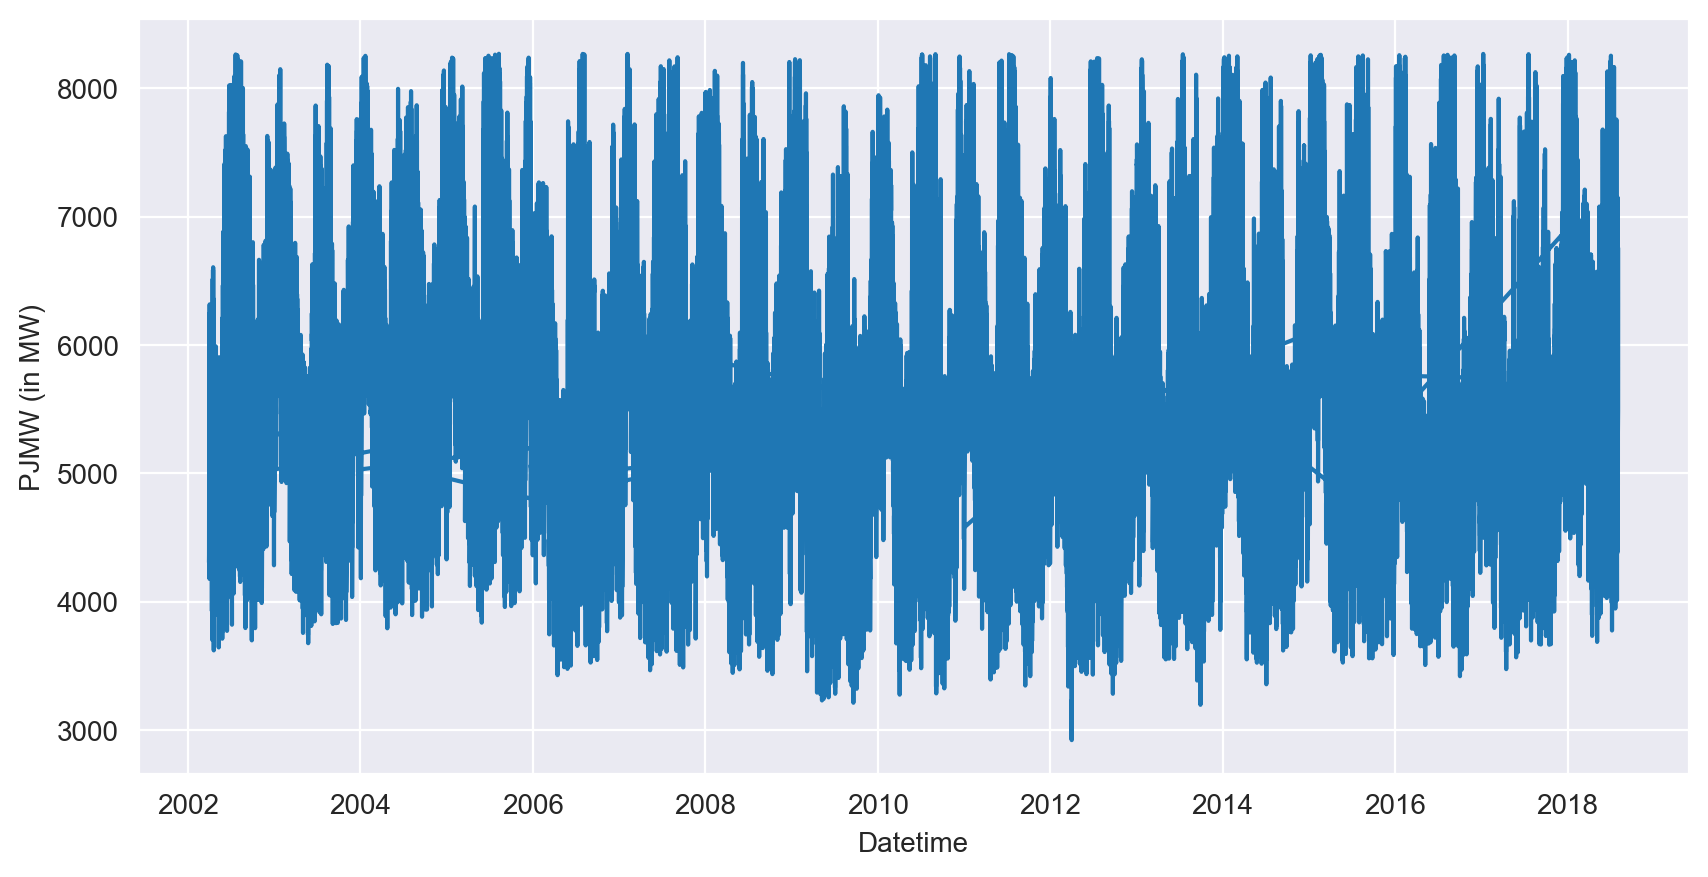

In [84]:
plt.plot(df['PJMW_MW'])
plt.xlabel('Datetime')
plt.ylabel('PJMW (in MW)')

<Axes: xlabel='PJMW_MW', ylabel='Density'>

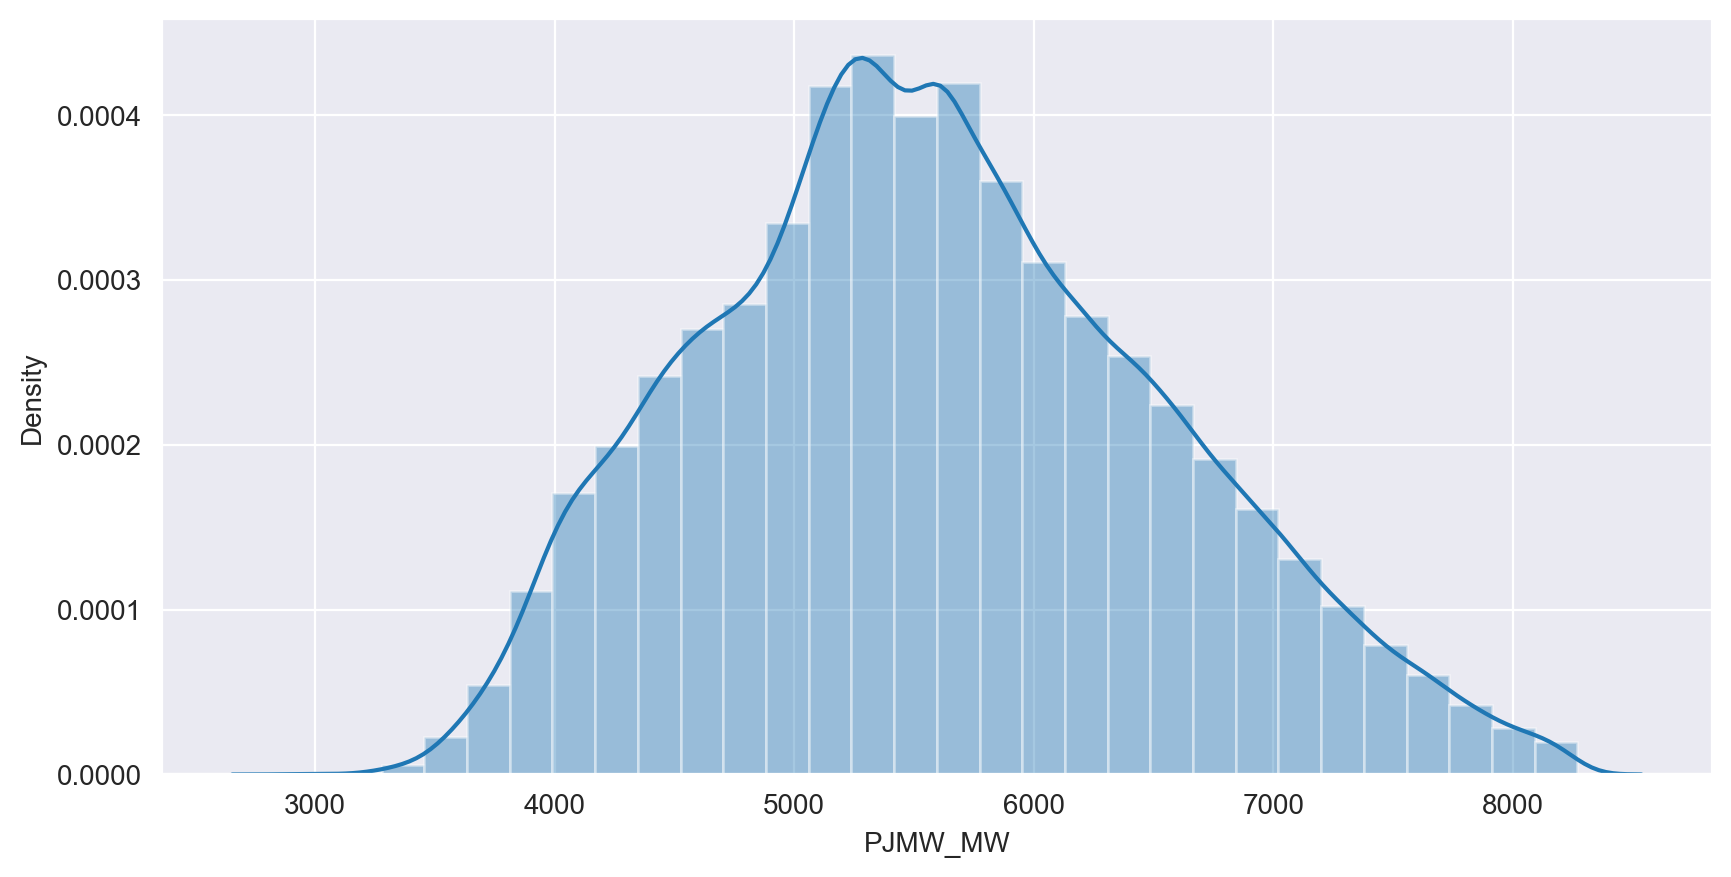

In [85]:
sns.distplot(df['PJMW_MW'], bins=30)

<Axes: xlabel='PJMW_MW', ylabel='Count'>

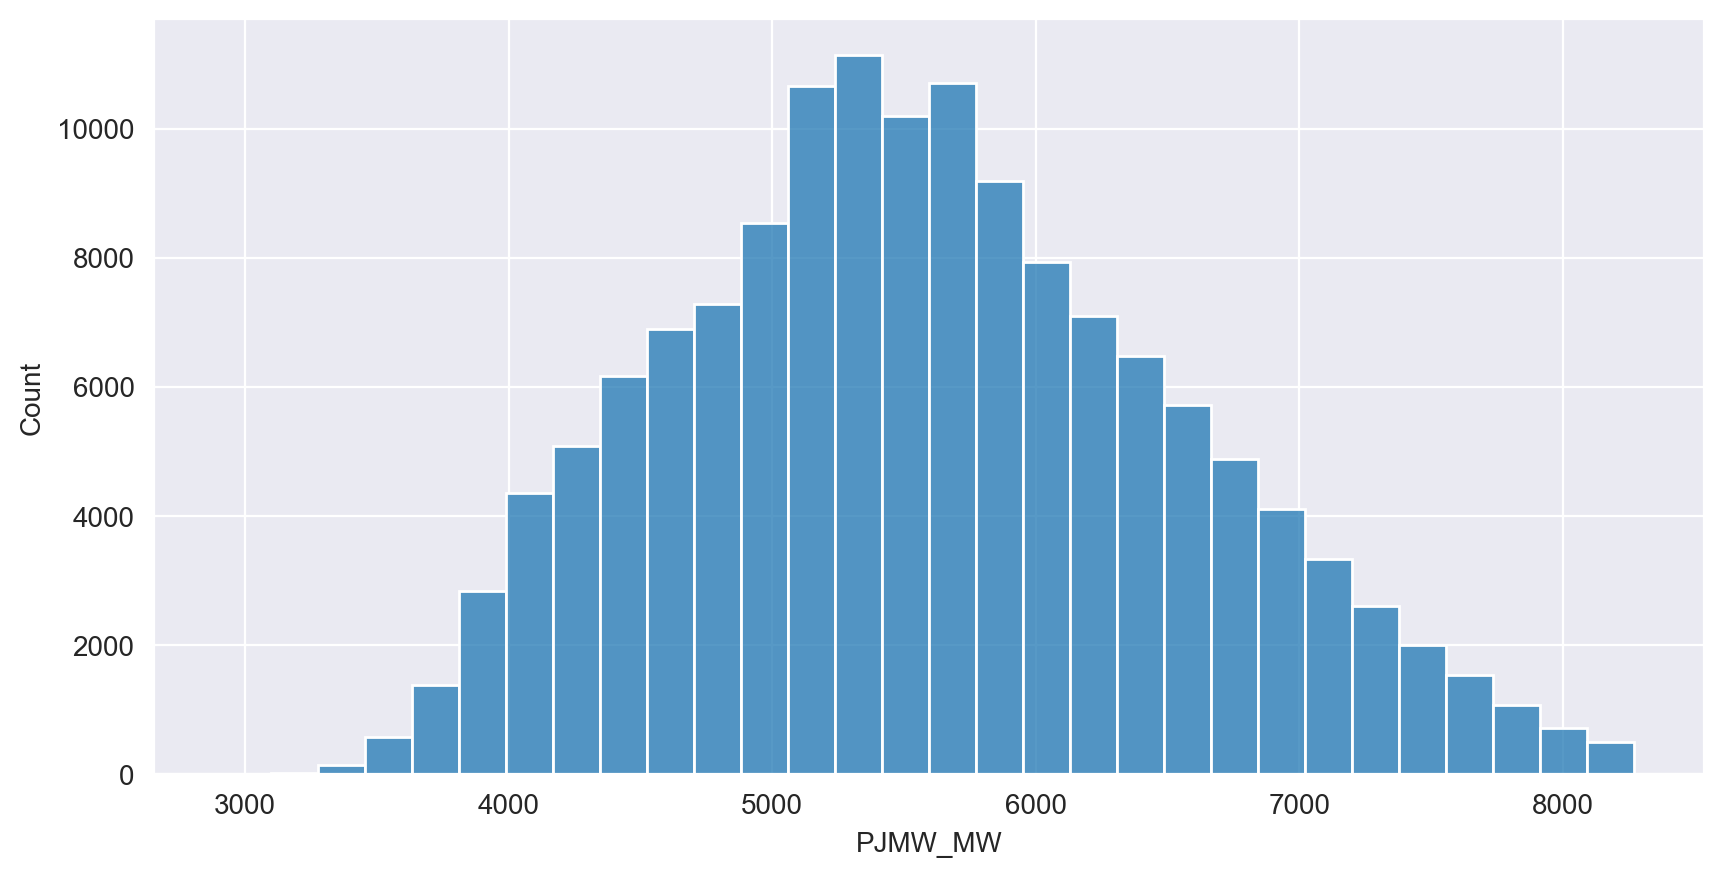

In [86]:
sns.histplot(df['PJMW_MW'], bins=30)

### From histogram we can say that the data is normally distributed

<Axes: xlabel='Datetime', ylabel='Density'>

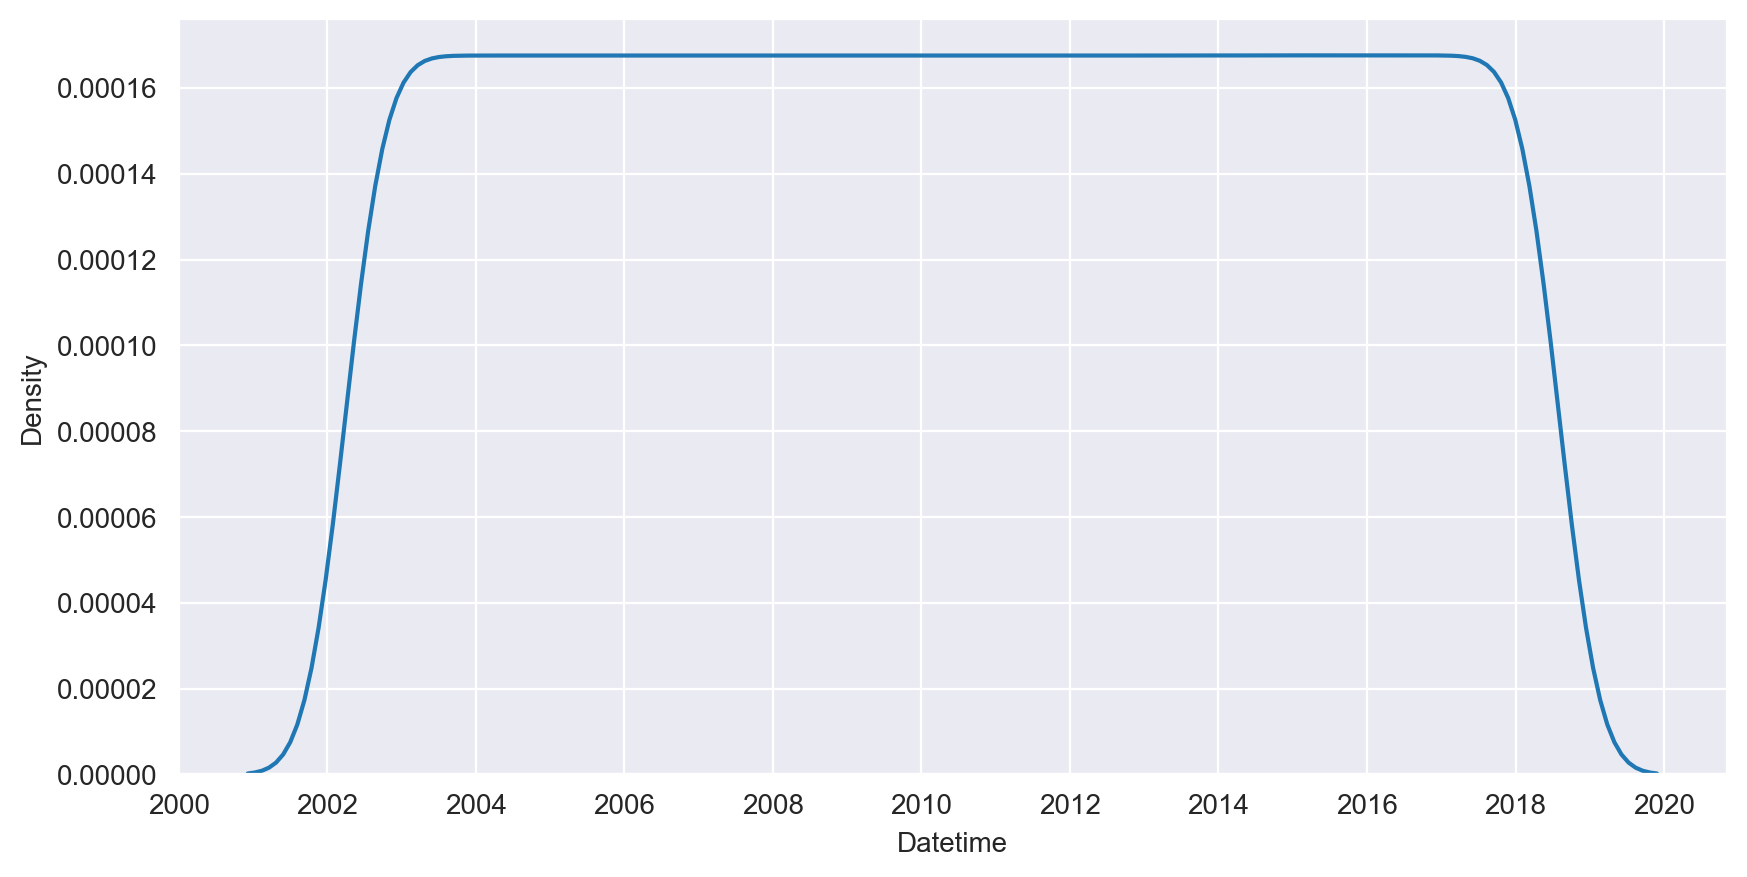

In [87]:
sns.kdeplot(df.index)

<Axes: xlabel='PJMW_MW'>

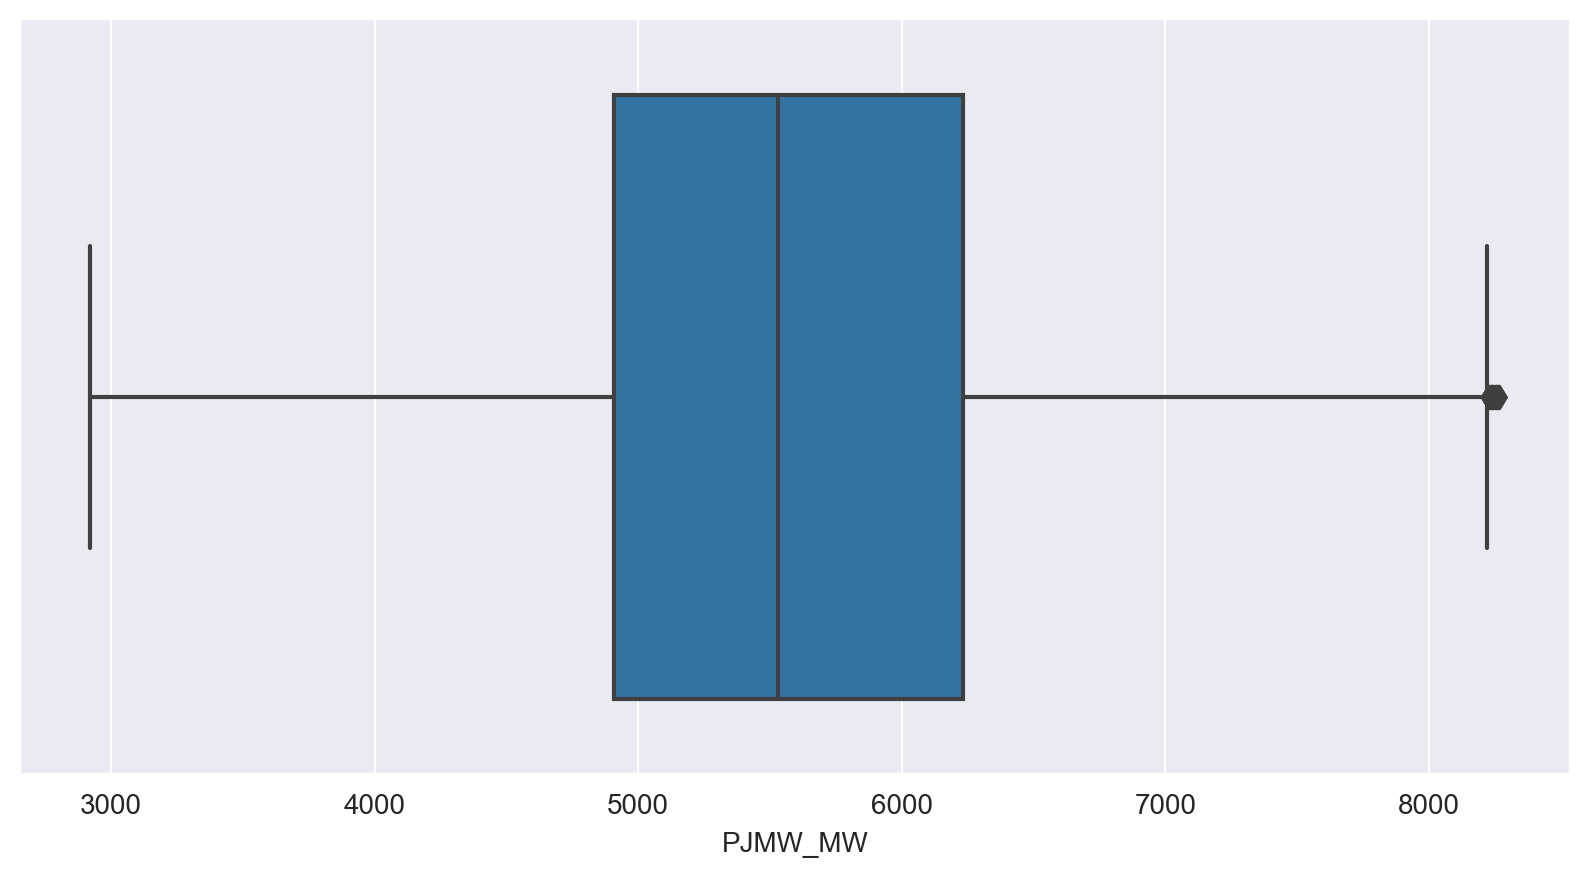

In [88]:
sns.boxplot(df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

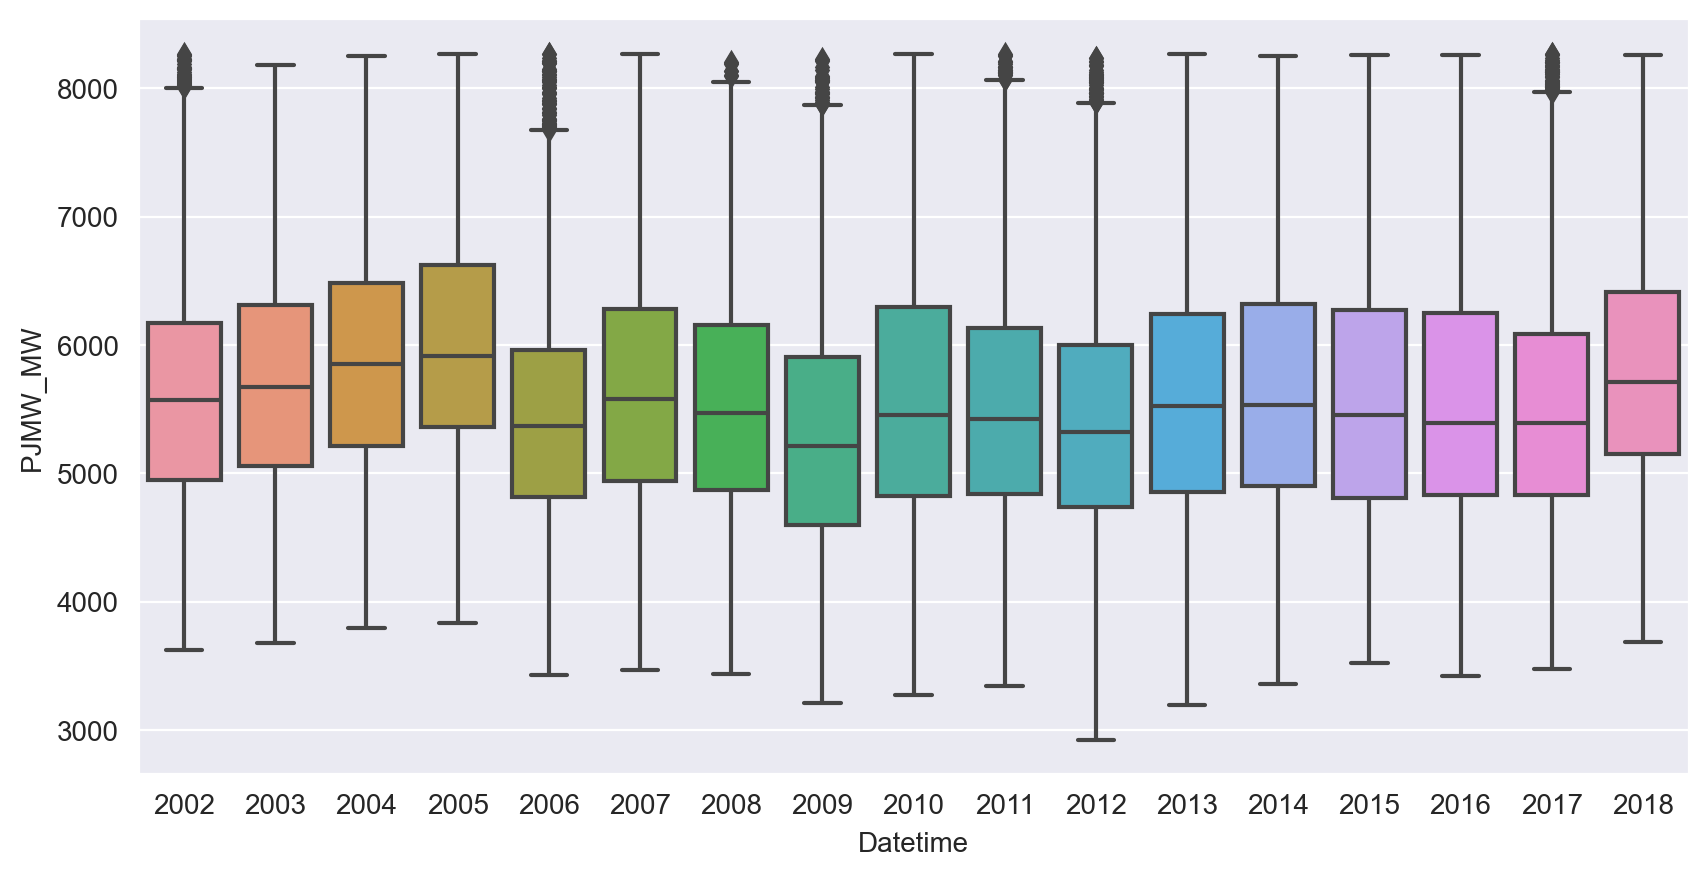

In [89]:
sns.boxplot(x=df.index.year, y=df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

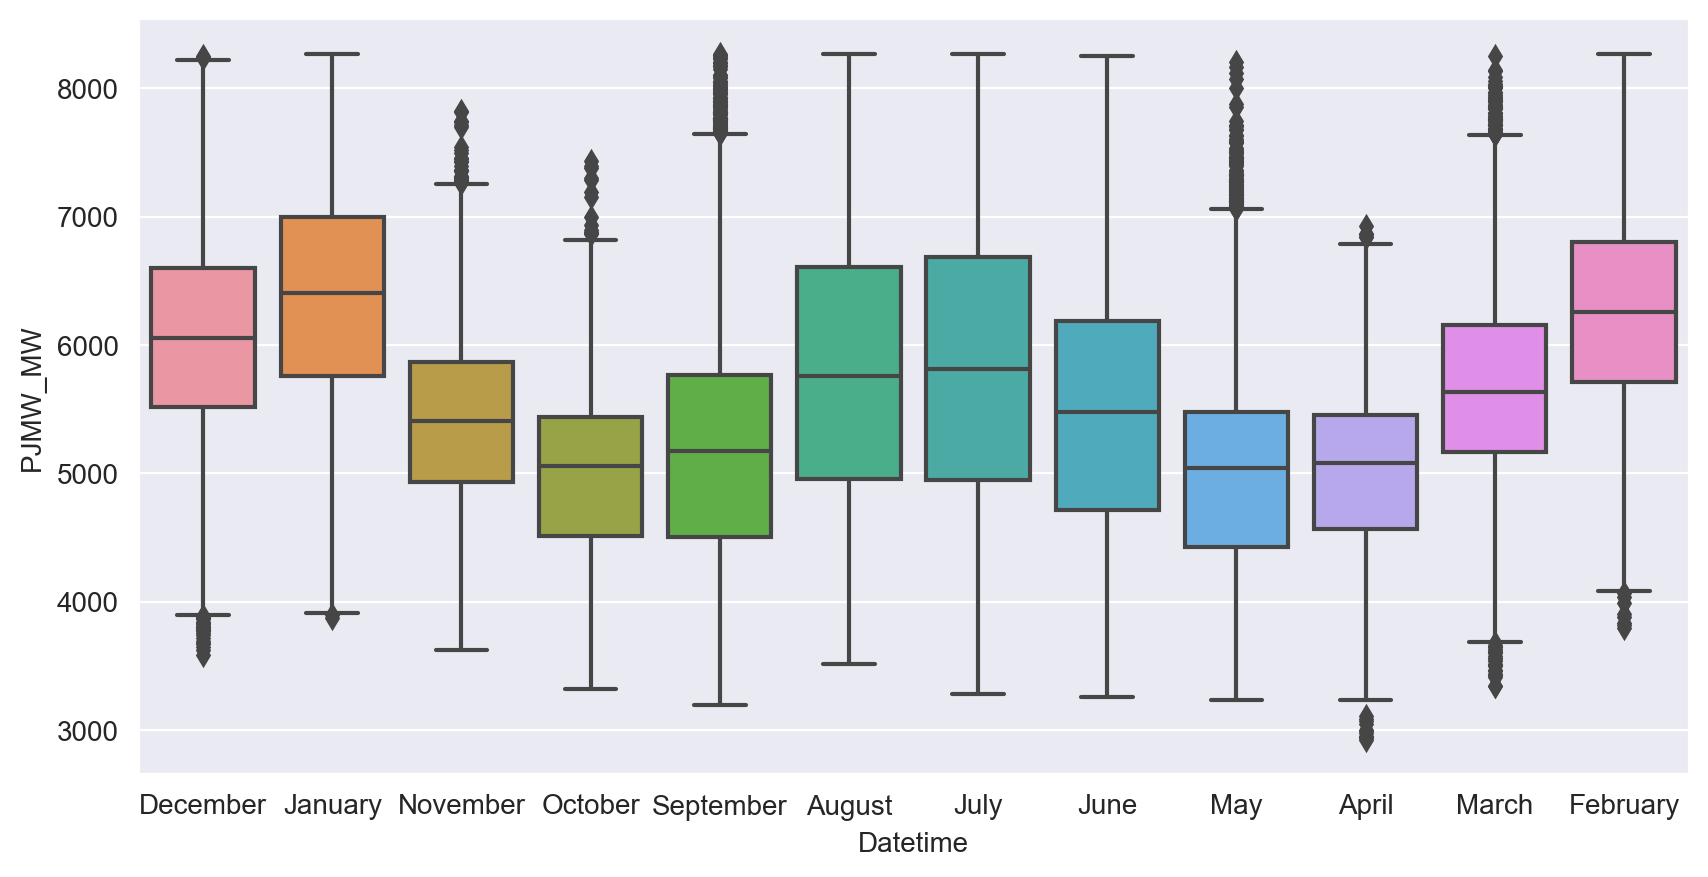

In [90]:
sns.boxplot(x=df.index.month_name(), y=df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

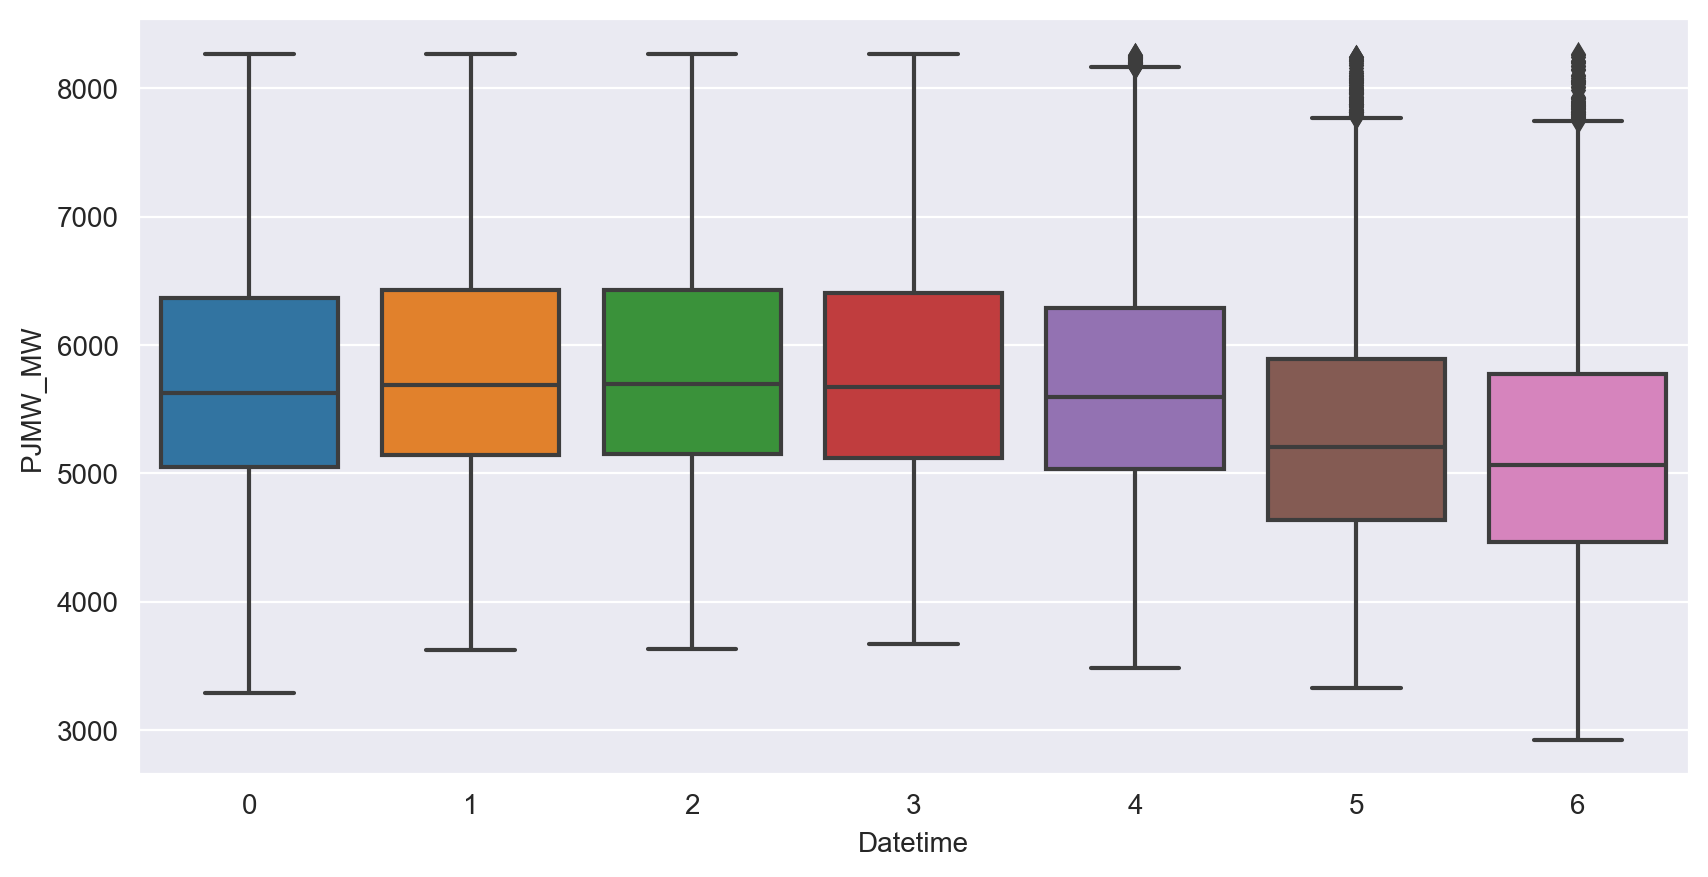

In [91]:
sns.boxplot(x=df.index.day_of_week, y=df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

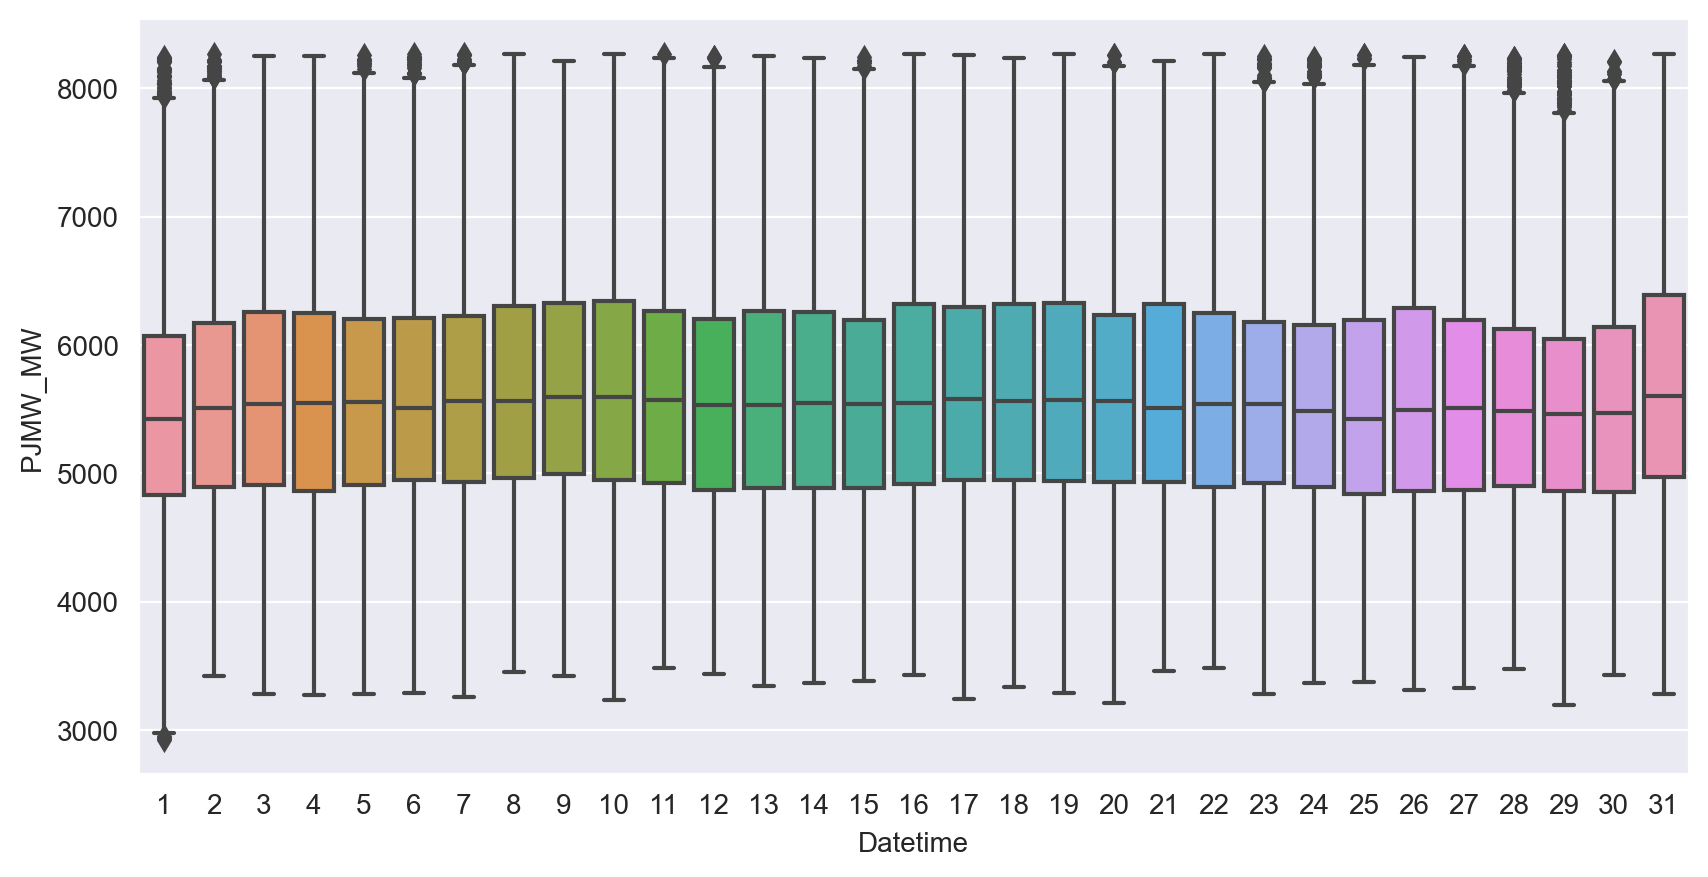

In [92]:
sns.boxplot(x=df.index.day, y=df['PJMW_MW'])

### In above graph instead of using month we use month_name() because our datetime series starts form 'December' instead of 'January' and it gives numbers according to datetime series sequence ie. December will be numbered as 1 instead of 12

In [93]:
# Total yearly usage
total_yearly_usage = df.groupby(df.index.year)["PJMW_MW"].sum()
total_yearly_usage

Datetime
2002    3.708075e+07
2003    4.992013e+07
2004    5.149523e+07
2005    5.256940e+07
2006    4.742072e+07
2007    4.928979e+07
2008    4.855190e+07
2009    4.630134e+07
2010    4.872192e+07
2011    4.816753e+07
2012    4.736652e+07
2013    4.860976e+07
2014    4.920886e+07
2015    4.886912e+07
2016    4.884999e+07
2017    4.814343e+07
2018    2.971410e+07
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

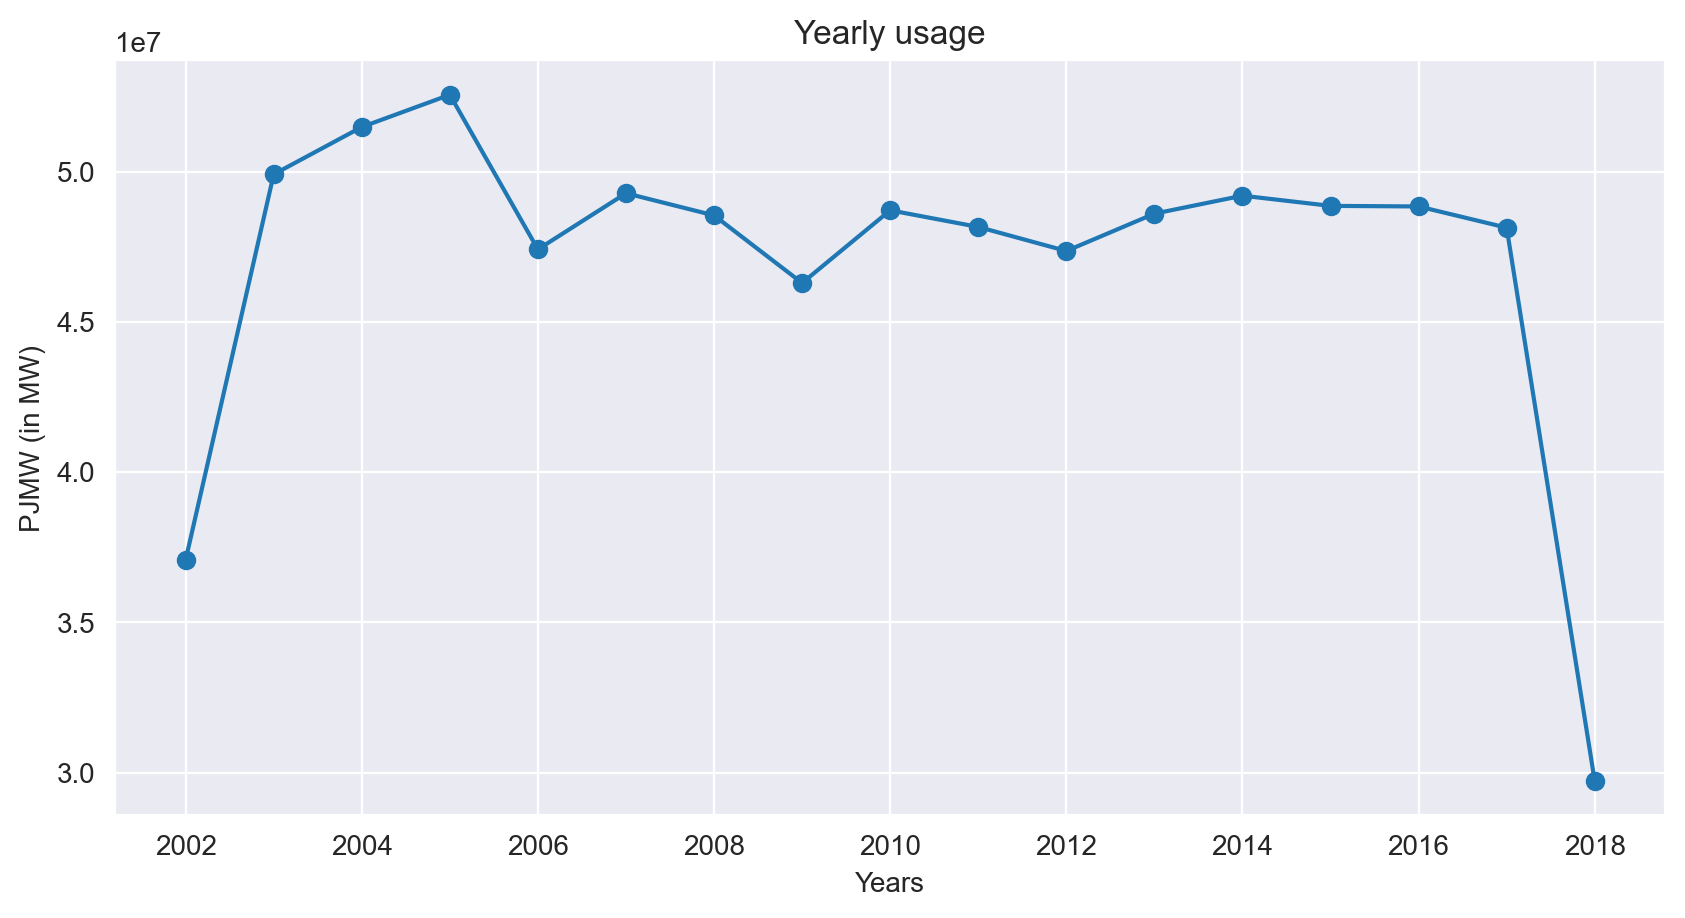

In [94]:
total_yearly_usage.plot(marker='o', title='Yearly usage')
plt.xlabel('Years')
plt.ylabel('PJMW (in MW)')

In [95]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

Text(0.5, 1.0, 'Total yearly usage')

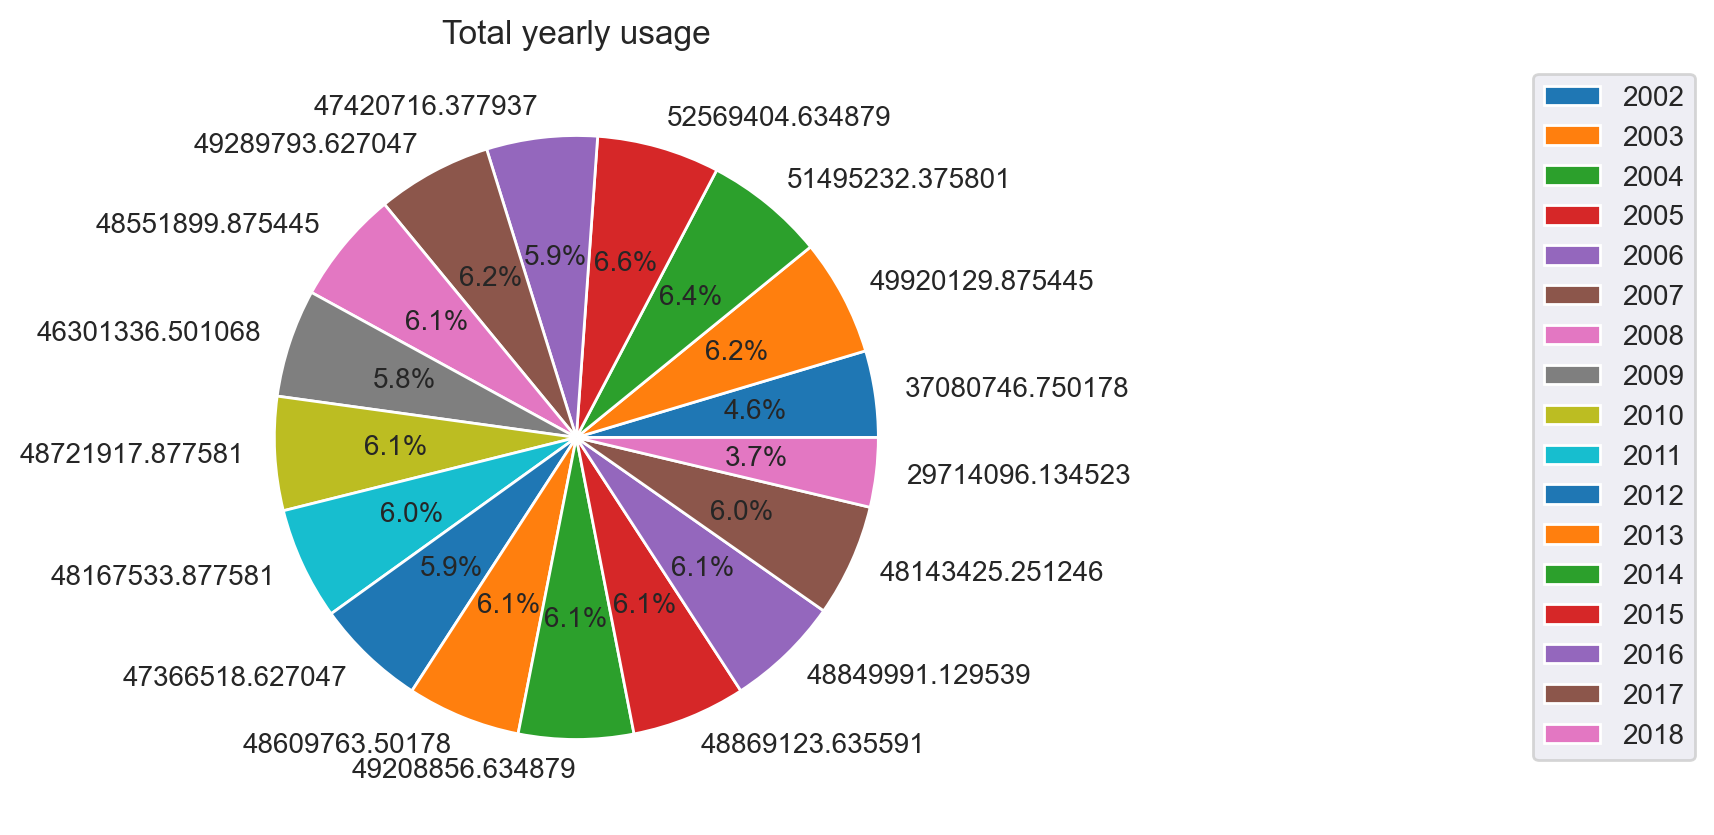

In [96]:
plt.pie(total_yearly_usage, labels=total_yearly_usage, autopct = lambda pct: func(pct, total_yearly_usage))
plt.legend(total_yearly_usage.index, bbox_to_anchor=(2, 1))
plt.title('Total yearly usage')

In [97]:
# Monthly usage across years
monthly_usage_across_years = pd.pivot_table(df, values='PJMW_MW', columns=df.index.month_name(), index=df.index.year)
monthly_usage_across_years

Datetime        April       August     December     February      January  \
Datetime                                                                    
2002      5171.318942  6063.909946  6154.673387          NaN          NaN   
2003      5232.509040  6024.669355  6266.799731  6402.547619  6571.360888   
2004      5426.936022  5910.219086  6365.185485  6393.234195  6825.047547   
2005      5380.983310  6291.373158  6538.086862  6433.568452  6511.711864   
2006      4788.084840  5922.498659  5692.561828  6041.986607  5753.059140   
2007      5215.961111  6038.365761  6046.346774  6674.837055  6038.096774   
2008      4959.263889  5458.784946  6015.278226  6279.462644  6268.275538   
2009      4849.751389  5540.622312  6031.521505  6017.994606  6509.489417   
2010      4738.938889  5805.691365  6457.680855  6378.889881  6406.479839   
2011      4961.569444  5709.915323  5704.434140  6106.610119  6526.014449   
2012      4789.779689  5659.037634  5711.481183  5833.787356  6116.665323   
2013      4944.922222  5446.470430  6080.012097  6362.821429  6201.694725   
2014      4977.568056  5482.196237  6047.541667  6573.176713  6610.745979   
2015      4955.444444  5583.073925  5364.998656  6813.163331  6702.757731   
2016      4937.476389  6198.550573  6090.001009  6214.280352  6435.645332   
2017      4805.781944  5609.067204  6338.652050  5692.532738  6073.387434   
2018      5281.277778  5874.346939          NaN  5979.610119  6500.203976   

Datetime         July         June        March          May     November  \
Datetime                                                                    
2002      6090.666331  5685.681944          NaN  5085.094086  5582.980556   
2003      5820.044355  5398.618056  5641.485215  5033.790827  5445.623611   
2004      5956.732527  5716.779167  5777.657258  5511.560484  5602.116667   
2005      6294.988410  6121.338022  6218.537634  5253.323925  5779.622222   
2006      5858.620129  5316.781944  5541.309140  4875.614247  5260.411111   
2007      5560.966398  5508.394444  5599.539704  5034.049731  5433.479833   
2008      5776.416667  5543.670660  5627.838493  4840.682796  5457.931850   
2009      5105.278226  5059.287500  5337.670256  4572.251344  4955.984701   
2010      5979.604336  5689.716667  5323.368775  4962.254032  5256.499305   
2011      5993.058807  5477.257465  5562.510094  4947.189516  5157.801113   
2012      5920.410283  5309.786112  5014.018843  5098.493280  5485.579972   
2013      5767.627186  5365.340278  5883.000000  4973.587366  5614.906815   
2014      5580.614247  5498.970833  6062.601447  4898.639785  5663.607490   
2015      5781.505376  5506.200000  6005.889805  5152.038978  5053.233010   
2016      5944.266802  5461.280556  5184.775236  4857.510753  5234.746186   
2017      5824.834510  5477.659722  5680.520861  4901.551075  5473.181692   
2018      5937.760922  5536.410070  5973.189771  5278.620968          NaN   

Datetime      October    September  
Datetime                            
2002      5311.936743  5419.641667  
2003      5275.403769  5307.640278  
2004      5313.002692  5562.062500  
2005      5437.663526  5777.605556  
2006      5027.837147  4910.723611  
2007      5105.029570  5349.212500  
2008      4986.365591  5144.813889  
2009      4733.576613  4748.466667  
2010      4732.794355  5064.072222  
2011      4836.944892  5028.708333  
2012      4805.700269  4973.606944  
2013      4995.041667  5006.712500  
2014      4890.766129  5178.868056  
2015      4809.196237  5288.500000  
2016      4758.688172  5421.413889  
2017      4944.178763  5111.904167  
2018              NaN          NaN

Text(0, 0.5, 'PJMW (in MW)')

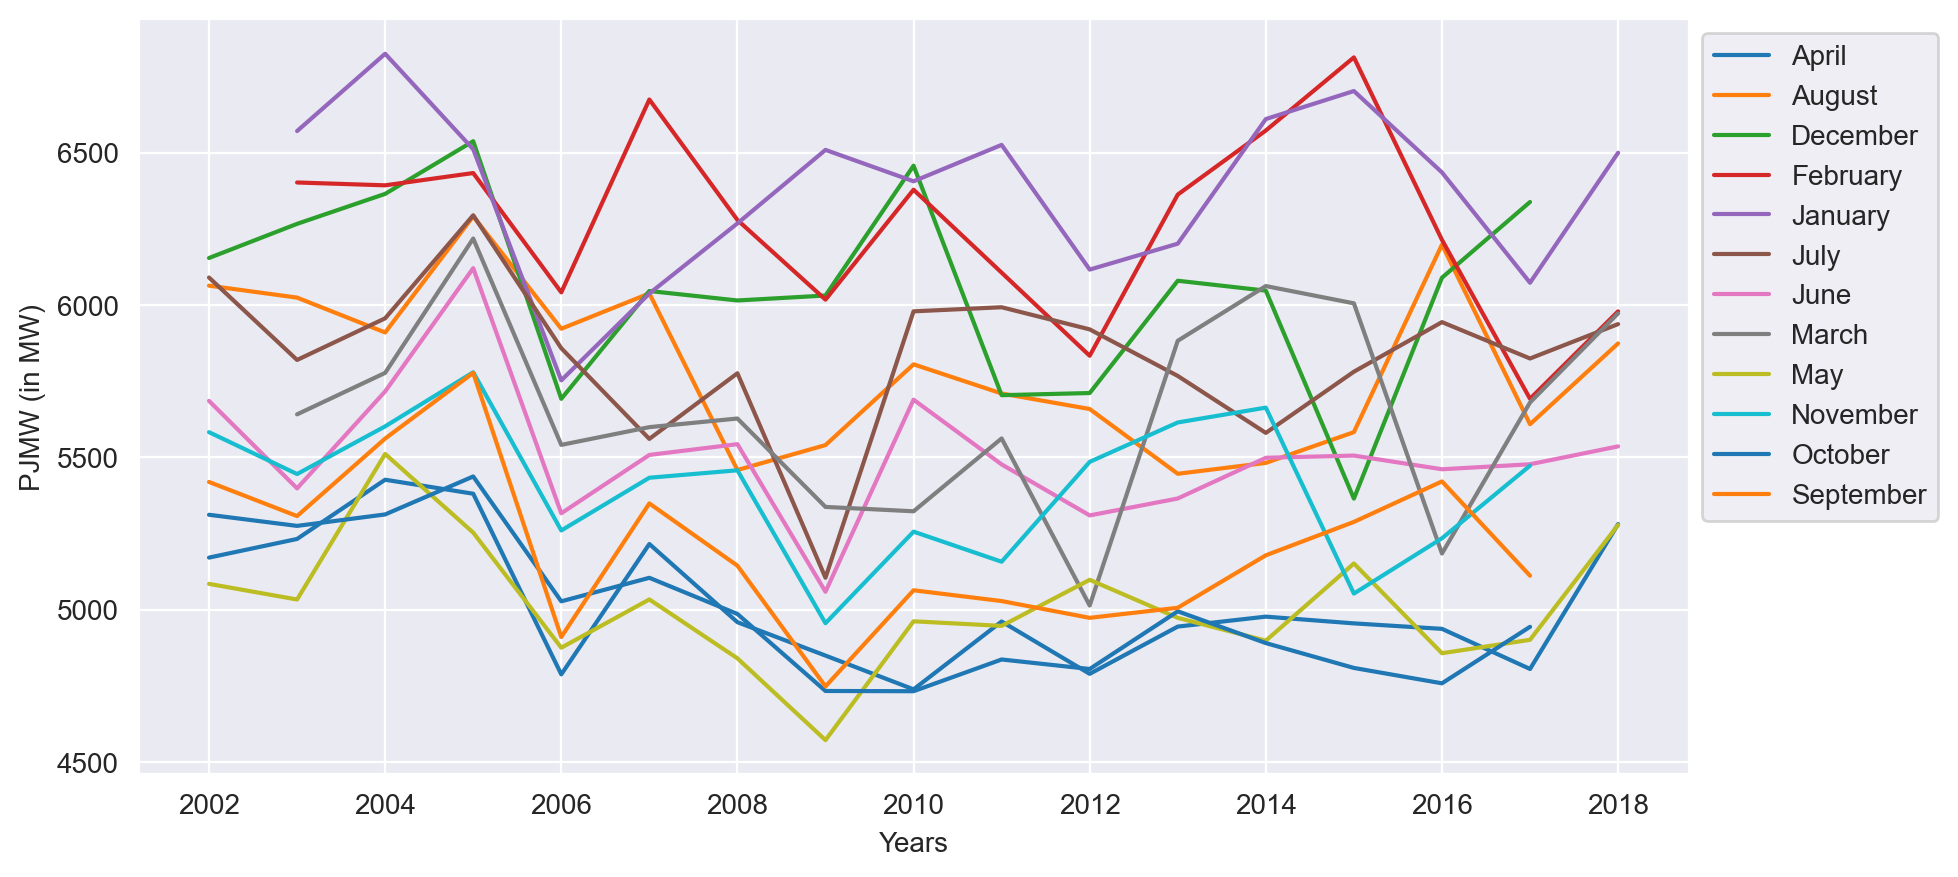

In [98]:
monthly_usage_across_years.plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Years')
plt.ylabel('PJMW (in MW)')

In [99]:
# Total monthly usage 
total_monthly_usage = monthly_usage_across_years.sum(axis=0, skipna=True)
total_monthly_usage

Datetime
April         85417.567398
August        98618.792852
December      96905.255455
February     100198.503217
January      102050.635954
July          99193.395511
June          93673.173441
March         90433.912532
May           85276.253192
November      86457.706132
October       79964.126134
September     83293.952778
dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

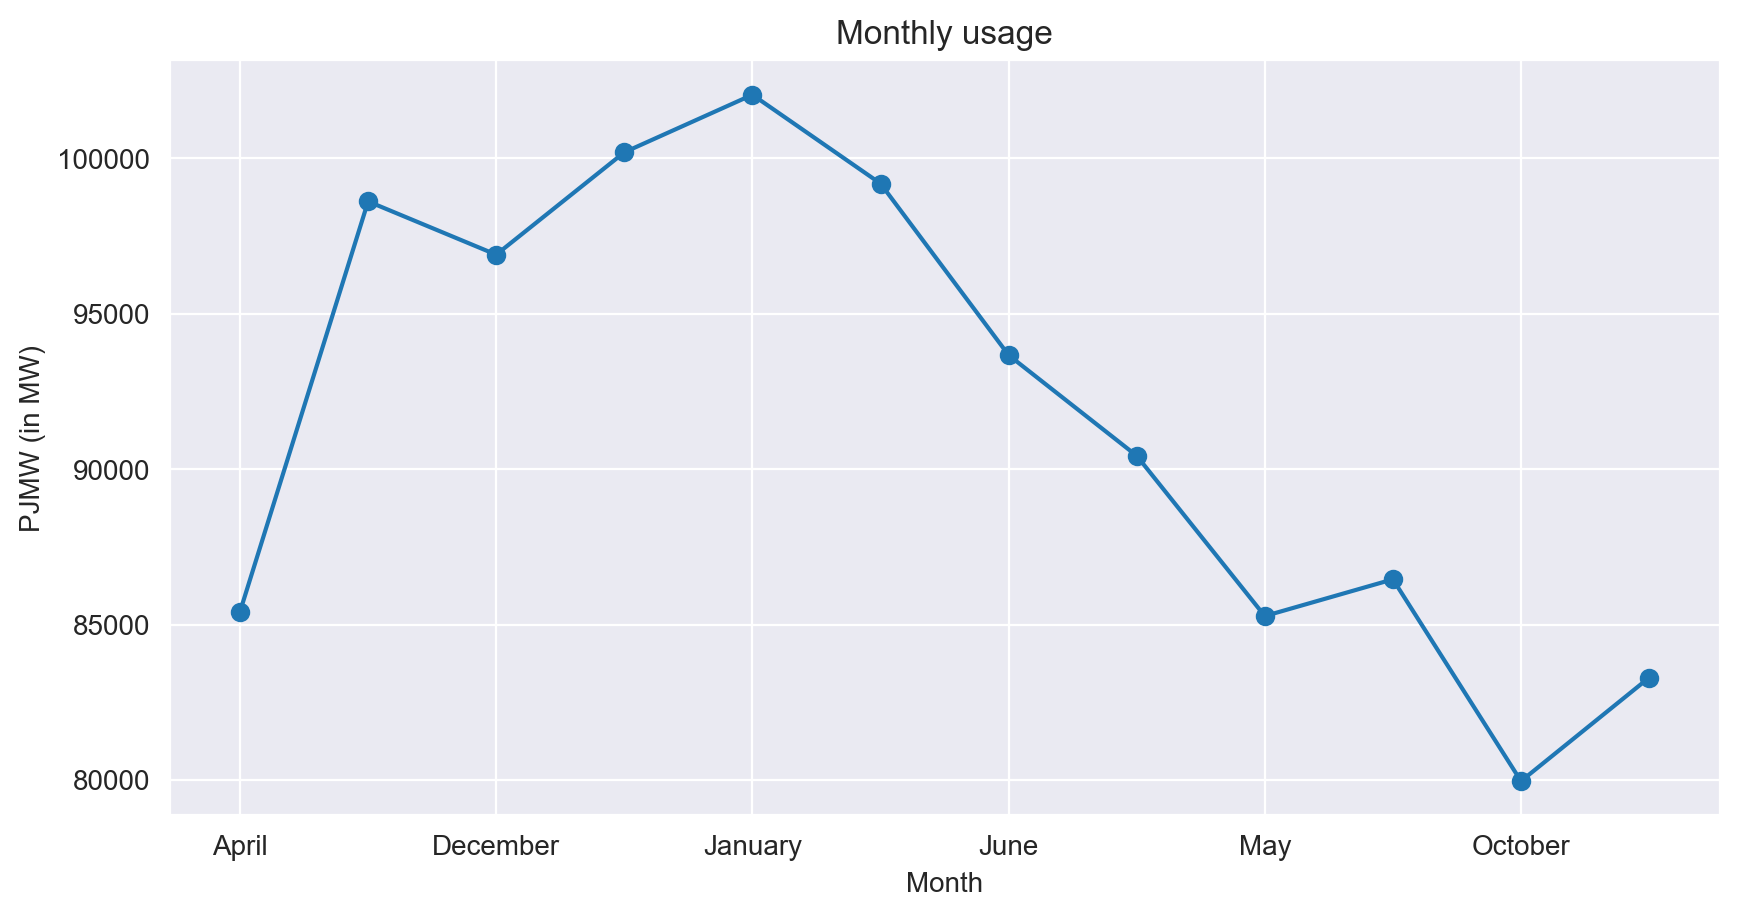

In [100]:
total_monthly_usage.plot(marker='o', title='Monthly usage')
plt.xlabel('Month')
plt.ylabel('PJMW (in MW)')

Text(0.5, 1.0, 'Total monthly usage')

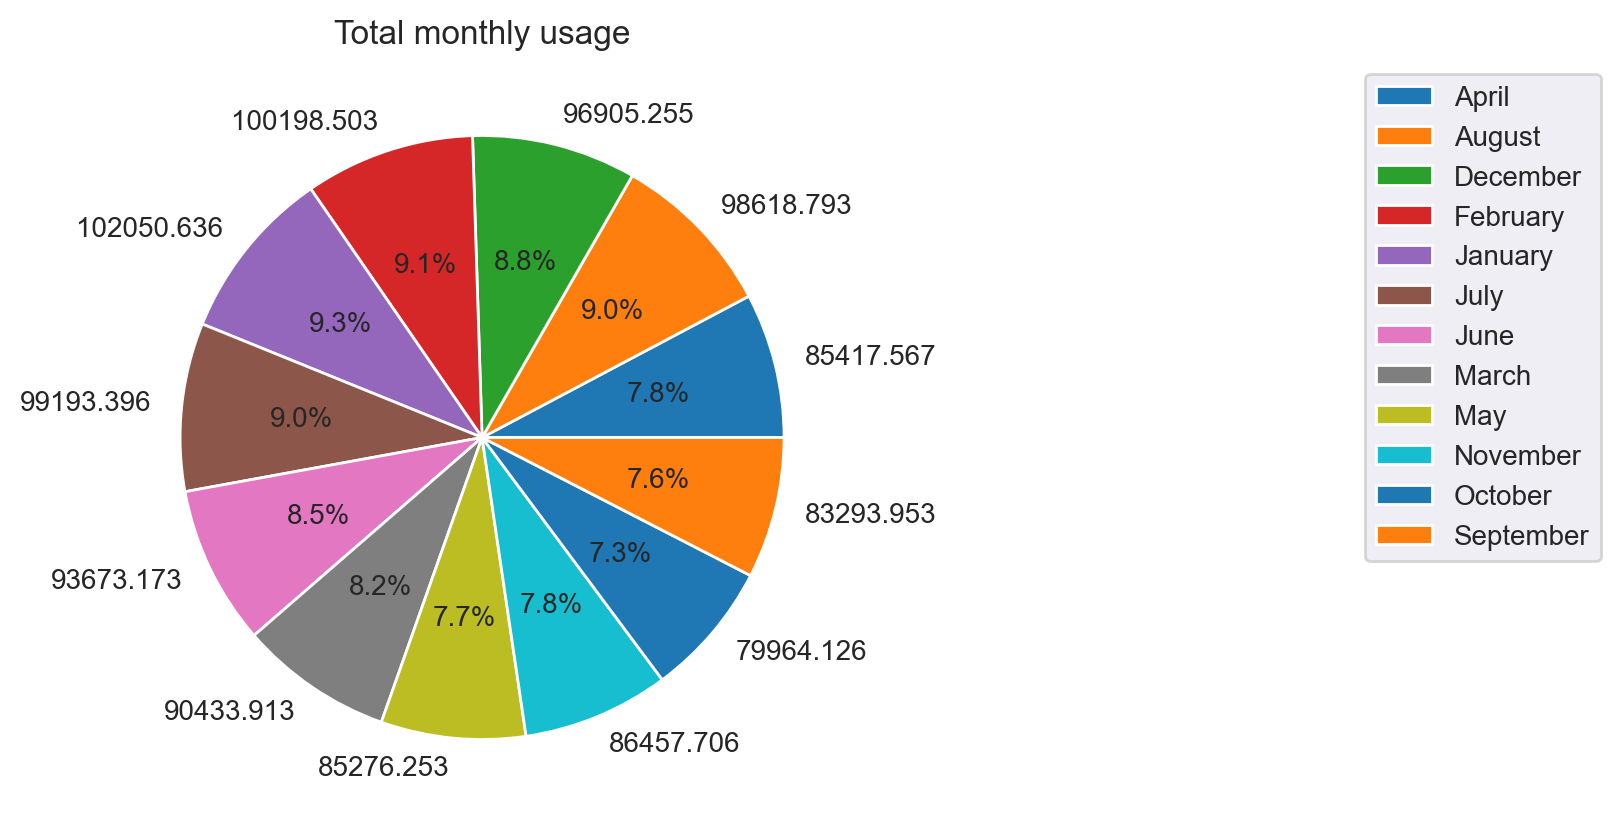

In [101]:
plt.pie(total_monthly_usage, labels=total_monthly_usage.round(3), autopct = lambda pct: func(pct, total_monthly_usage))
plt.legend(total_monthly_usage.index, bbox_to_anchor=(2, 1))
plt.title('Total monthly usage')

In [102]:
# Quarterly usage across years
quarterly_usage_over_years = pd.pivot_table(df, values='PJMW_MW', columns=df.index.quarter, index=df.index.year)
quarterly_usage_over_years

Datetime            1            2            3            4
Datetime                                                    
2002              NaN  5311.644363  5862.838202  5684.454916
2003      6198.550695  5219.569114  5721.905797  5665.144087
2004      6330.633414  5551.373798  5812.362772  5762.022202
2005      6386.418346  5581.659815  6125.058427  5920.185150
2006      5770.011574  4992.291800  5571.047726  5327.795650
2007      6085.360121  5250.397894  5652.779043  5529.359311
2008      6053.864865  5111.529705  5463.431159  5486.849116
2009      5953.238305  4824.296245  5135.618659  5243.582238
2010      6025.149606  5128.456502  5622.460146  5484.441920
2011      6063.891501  5126.677827  5583.189652  5233.912551
2012      5651.182318  5066.376546  5523.598845  5332.539647
2013      6142.170392  5093.286630  5411.286968  5562.735841
2014      6410.413448  5122.571429  5416.447464  5532.622001
2015      6497.301360  5203.983974  5553.879982  5076.044364
2016      5939.325356  5082.918040  5859.453862  5362.461182
2017      5819.643006  5059.904762  5519.653023  5586.505263
2018      6156.799332  5364.482258  5933.842530          NaN

Text(0, 0.5, 'PJMW (in MW)')

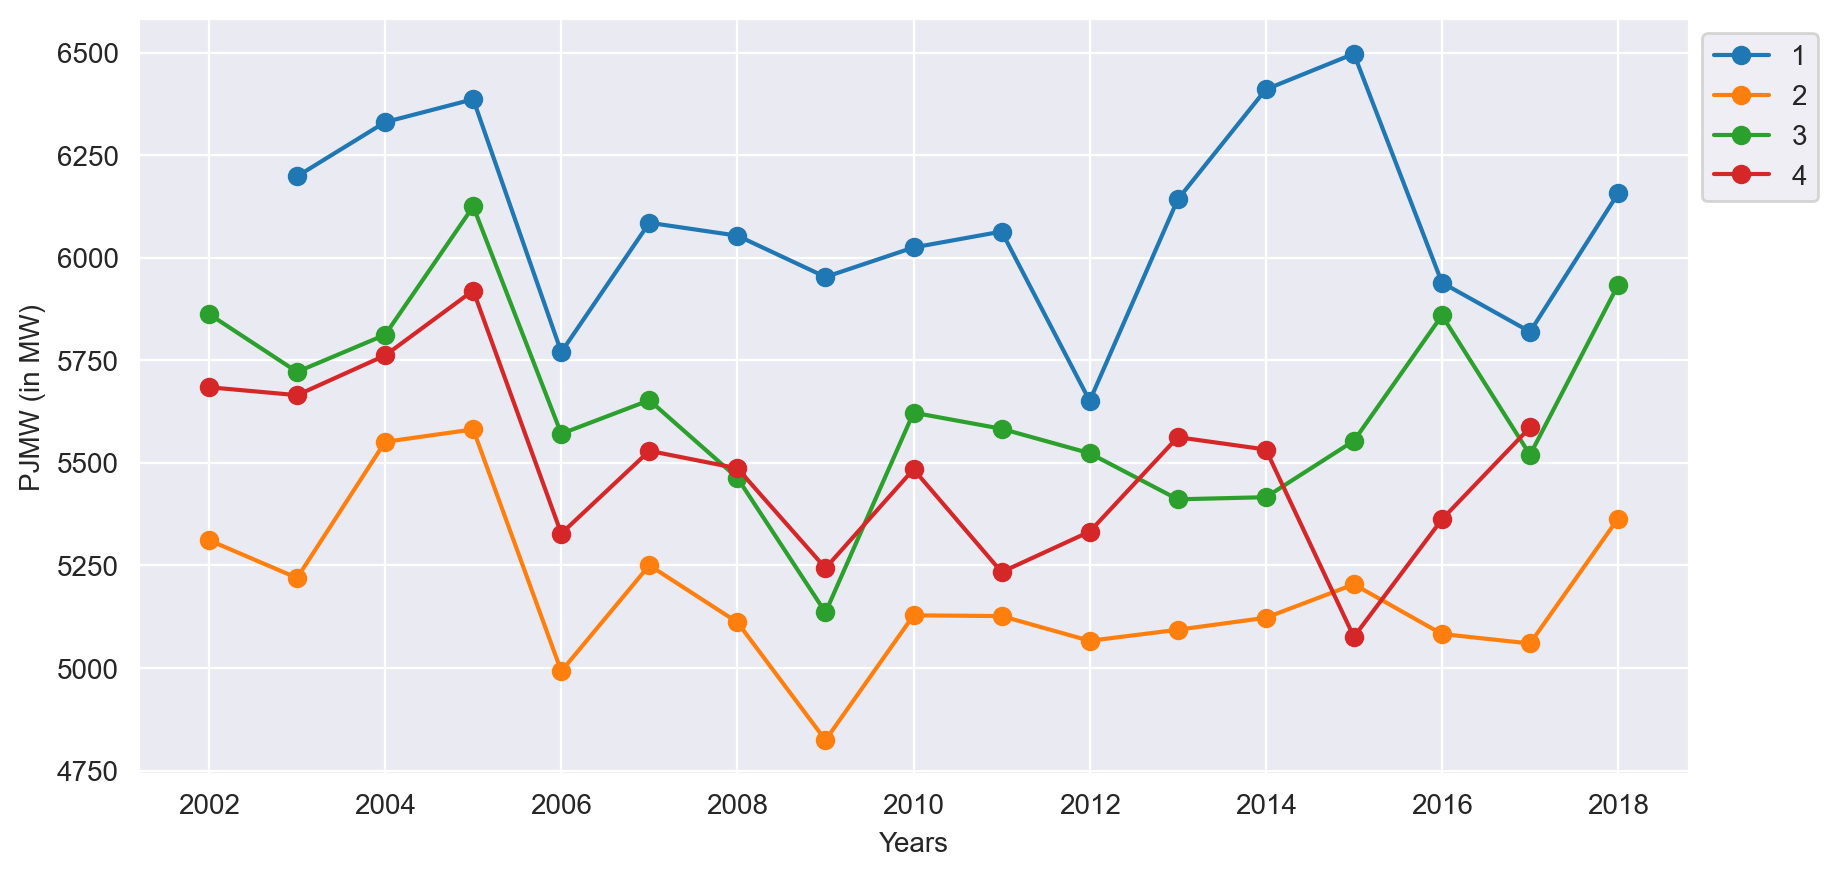

In [103]:
quarterly_usage_over_years.plot(marker='o')
plt.legend(quarterly_usage_over_years, bbox_to_anchor=(1, 1))
plt.xlabel('Years')
plt.ylabel('PJMW (in MW)')

In [104]:
# Total quarterly usage
total_quarterly_usage = quarterly_usage_over_years.sum(axis=0, skipna=True)
total_quarterly_usage

Datetime
1    97483.953638
2    88091.420701
3    95768.854257
4    87790.655439
dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

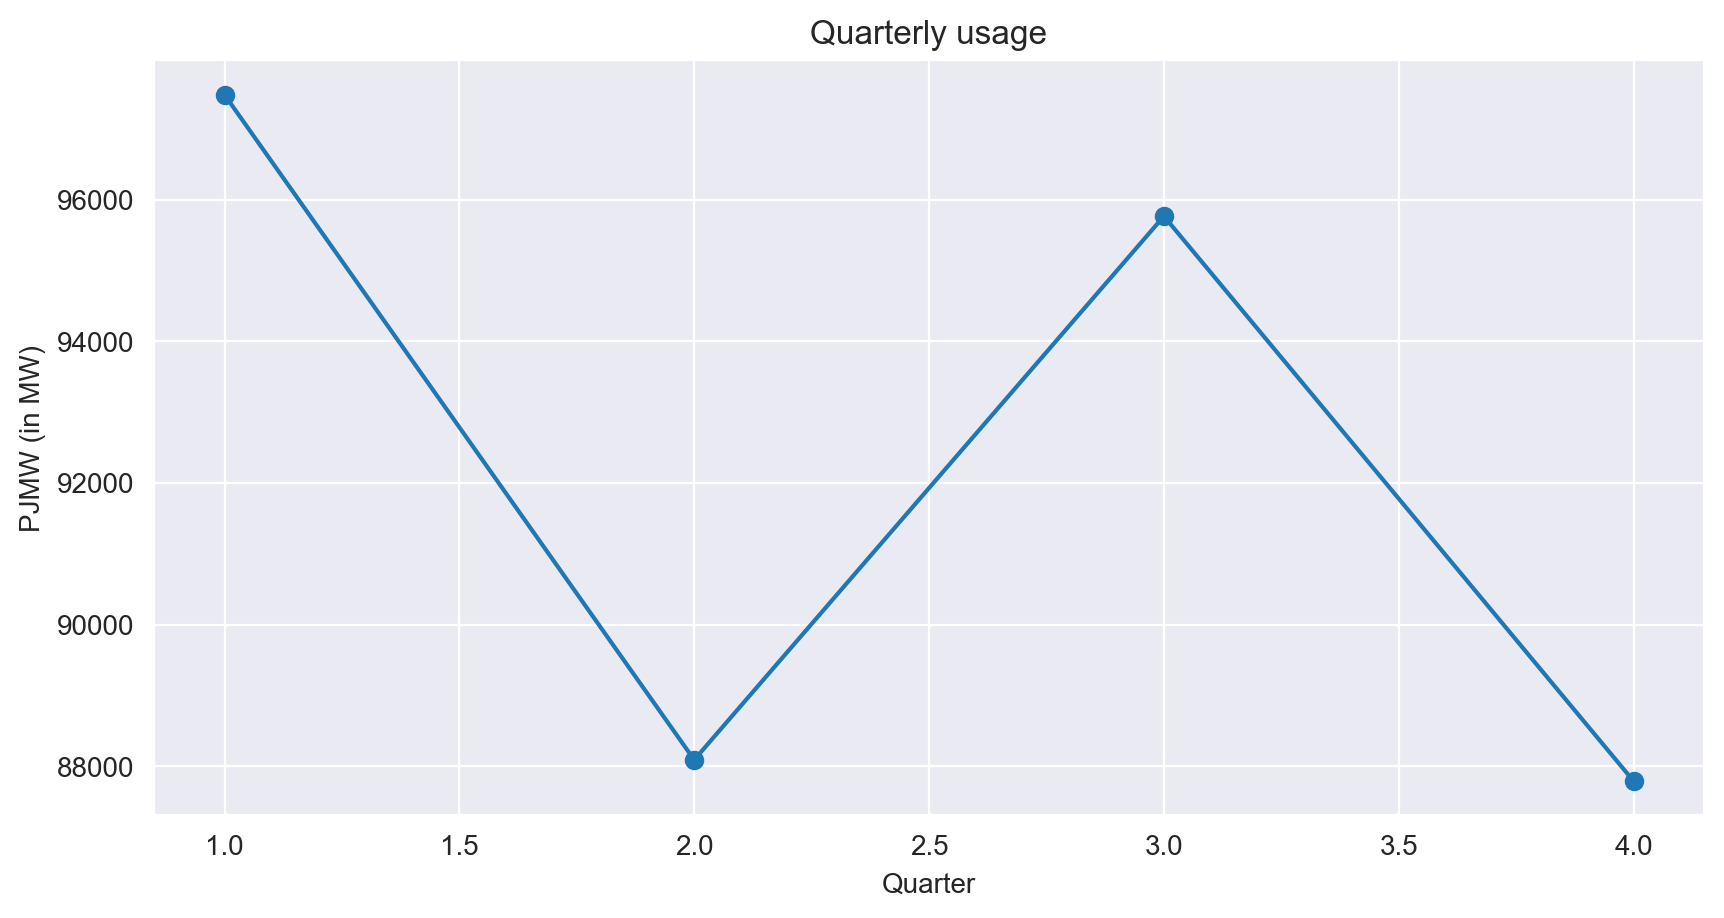

In [105]:
total_quarterly_usage.plot(marker='o', title='Quarterly usage')
plt.xlabel('Quarter')
plt.ylabel('PJMW (in MW)')

Text(0.5, 1.0, 'Total quarterly usage')

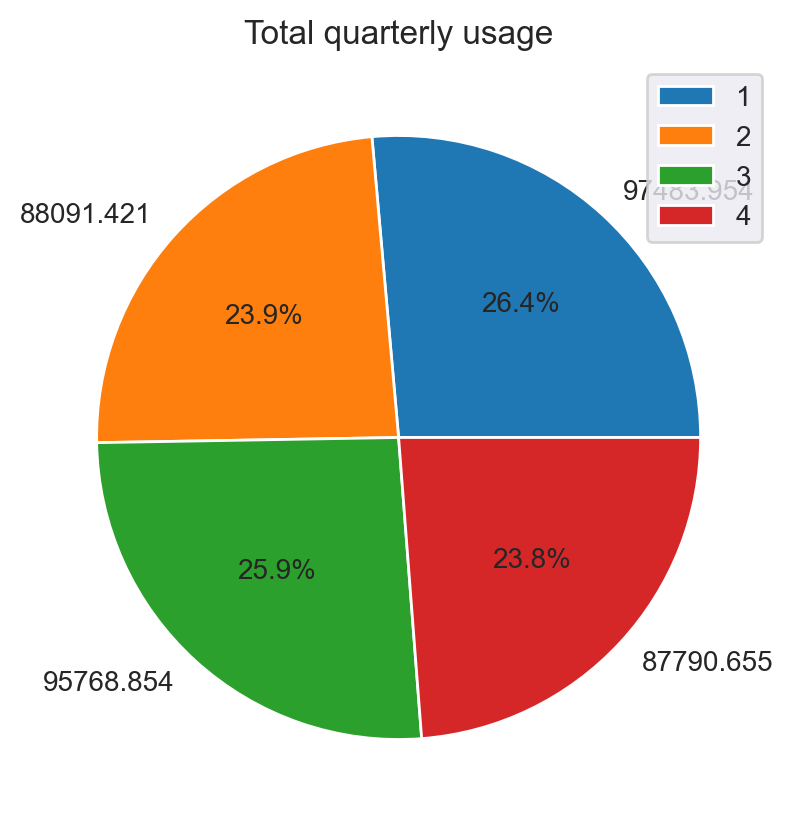

In [106]:
plt.pie(total_quarterly_usage, labels=total_quarterly_usage.round(3), autopct = lambda pct: func(pct, total_quarterly_usage))
plt.legend(total_quarterly_usage.index, bbox_to_anchor=(1, 1))
plt.title('Total quarterly usage')

Text(0.5, 0, 'PJMW (in MW)')

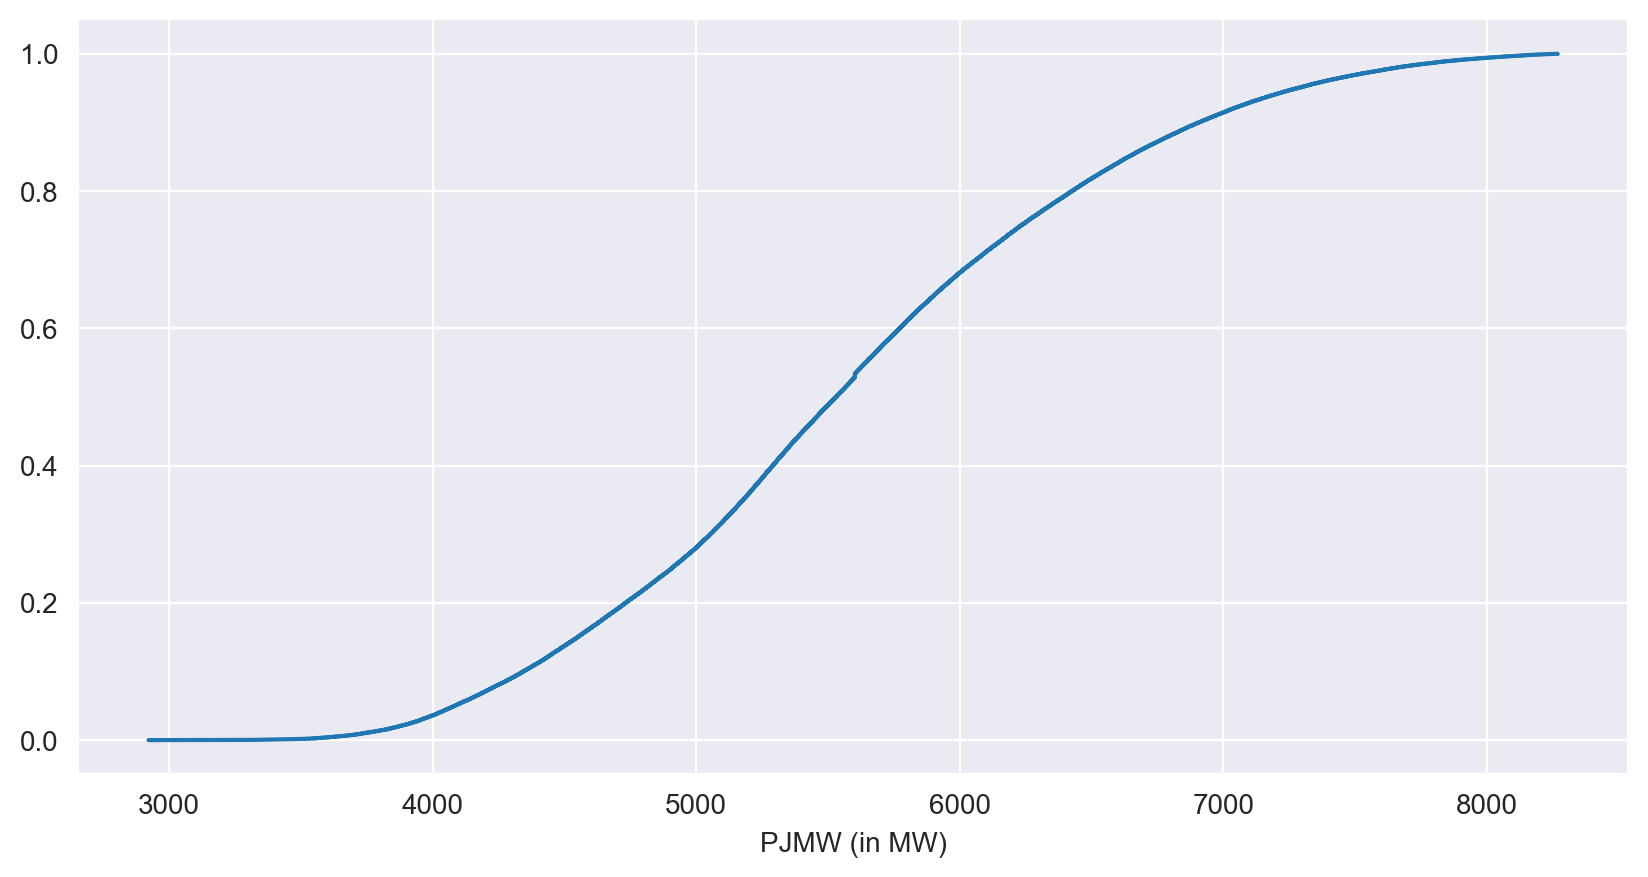

In [196]:
# Plotting of Empirical Cumulative Distribution Function
from statsmodels.distributions.empirical_distribution import ECDF
cdf = ECDF(df['PJMW_MW'])
plt.plot(cdf.x, cdf.y)
plt.xlabel('PJMW (in MW)')

### From above graph we ca see that around 60% of PJMW (power usage) is 5600 MW or less

In [108]:
# Average usage per year
average_year = df.groupby(df.index.year)["PJMW_MW"].mean()
average_year

Datetime
2002    5620.849894
2003    5699.946321
2004    5863.724935
2005    6002.444009
2006    5414.559988
2007    5627.973696
2008    5528.569788
2009    5286.747716
2010    5563.768171
2011    5499.832596
2012    5393.591281
2013    5550.326958
2014    5617.449388
2015    5578.667082
2016    5561.246713
2017    5495.824800
2018    5785.454855
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

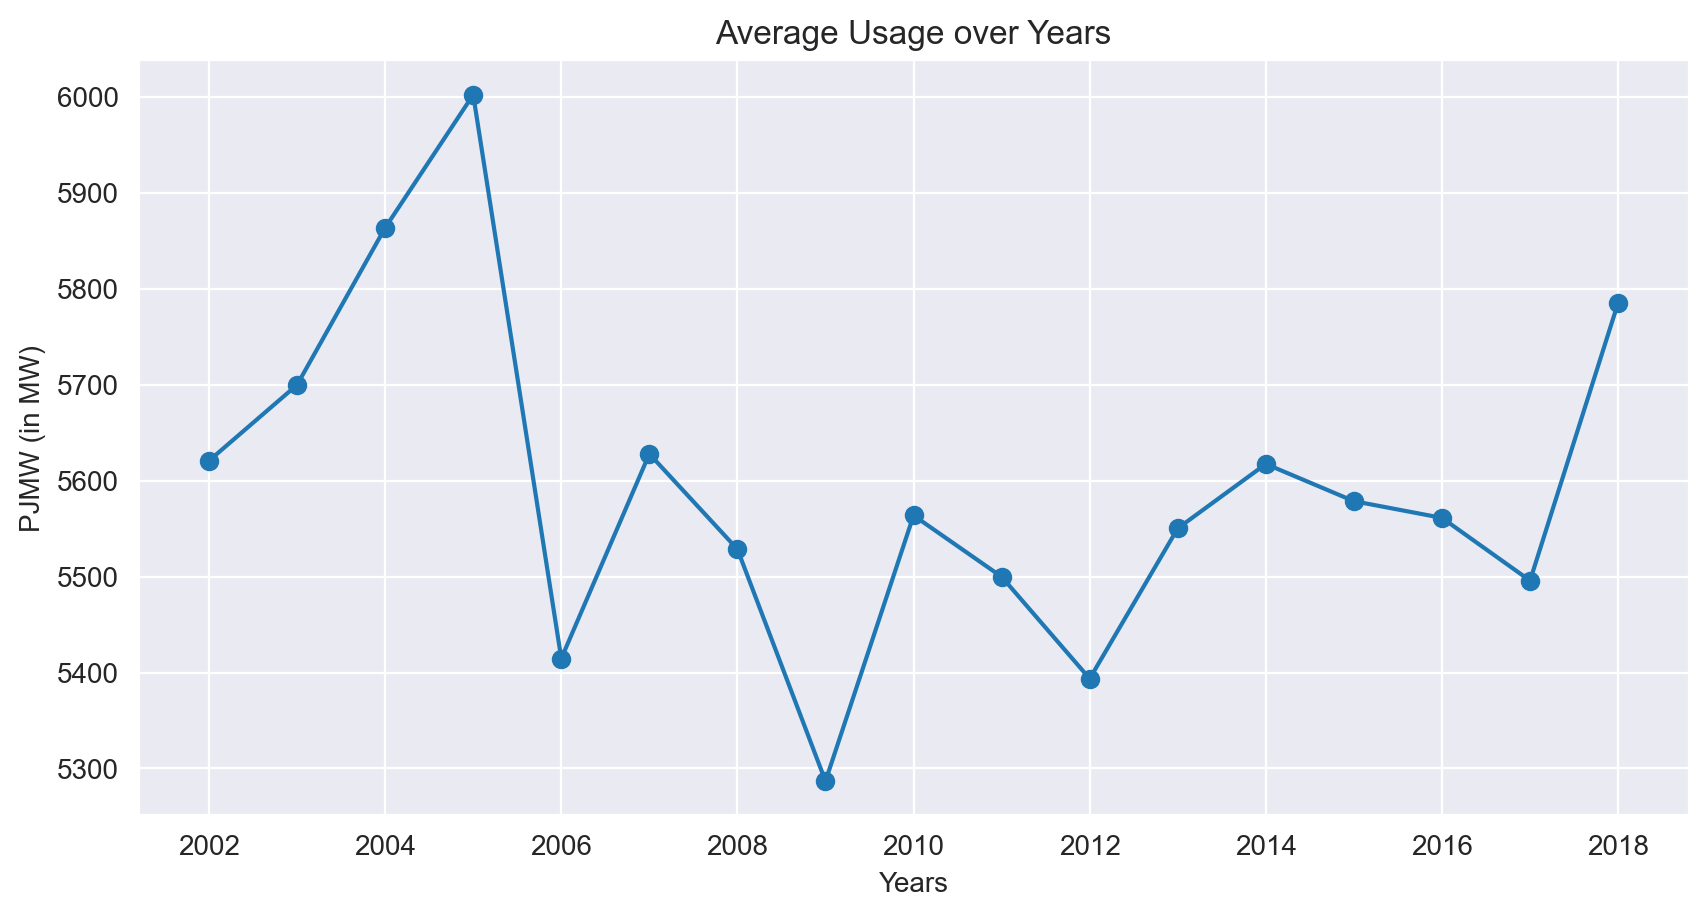

In [109]:
average_year.plot(marker='o', title='Average Usage over Years')
plt.xlabel('Years')
plt.ylabel('PJMW (in MW)')

In [110]:
# Average usage per month
average_month = df.groupby(df.index.month_name())["PJMW_MW"].mean()
average_month

Datetime
April        5024.479105
August       5796.846880
December     6056.544768
February     6261.678882
January      6378.164747
July         5834.905618
June         5510.186673
March        5652.167508
May          5016.250188
November     5403.630372
October      4997.642155
September    5205.872049
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'PJMW (in MW)')

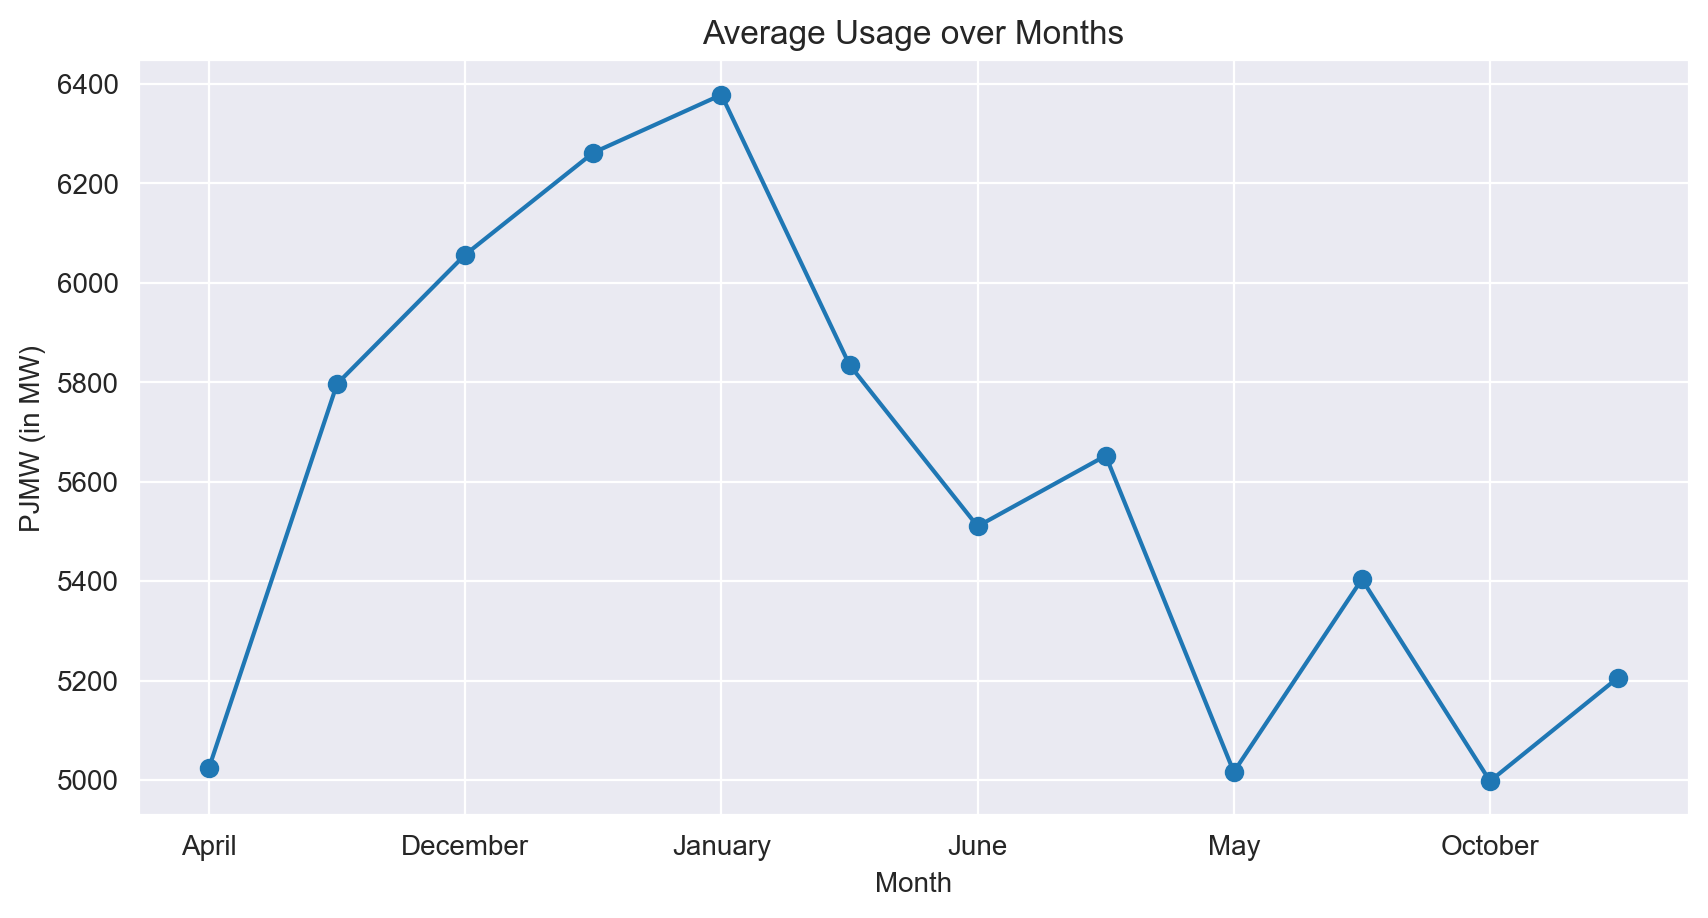

In [111]:
average_month.plot(marker='o', title='Average Usage over Months')
plt.xlabel('Month')
plt.ylabel('PJMW (in MW)')

In [112]:
# Percentage change of power usage per year 
pct_change_year = df.groupby(df.index.year)["PJMW_MW"].sum().pct_change()
pct_change_year

Datetime
2002         NaN
2003    0.346255
2004    0.031552
2005    0.020860
2006   -0.097941
2007    0.039415
2008   -0.014971
2009   -0.046354
2010    0.052279
2011   -0.011379
2012   -0.016630
2013    0.026247
2014    0.012325
2015   -0.006904
2016   -0.000392
2017   -0.014464
2018   -0.382801
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'Percentage')

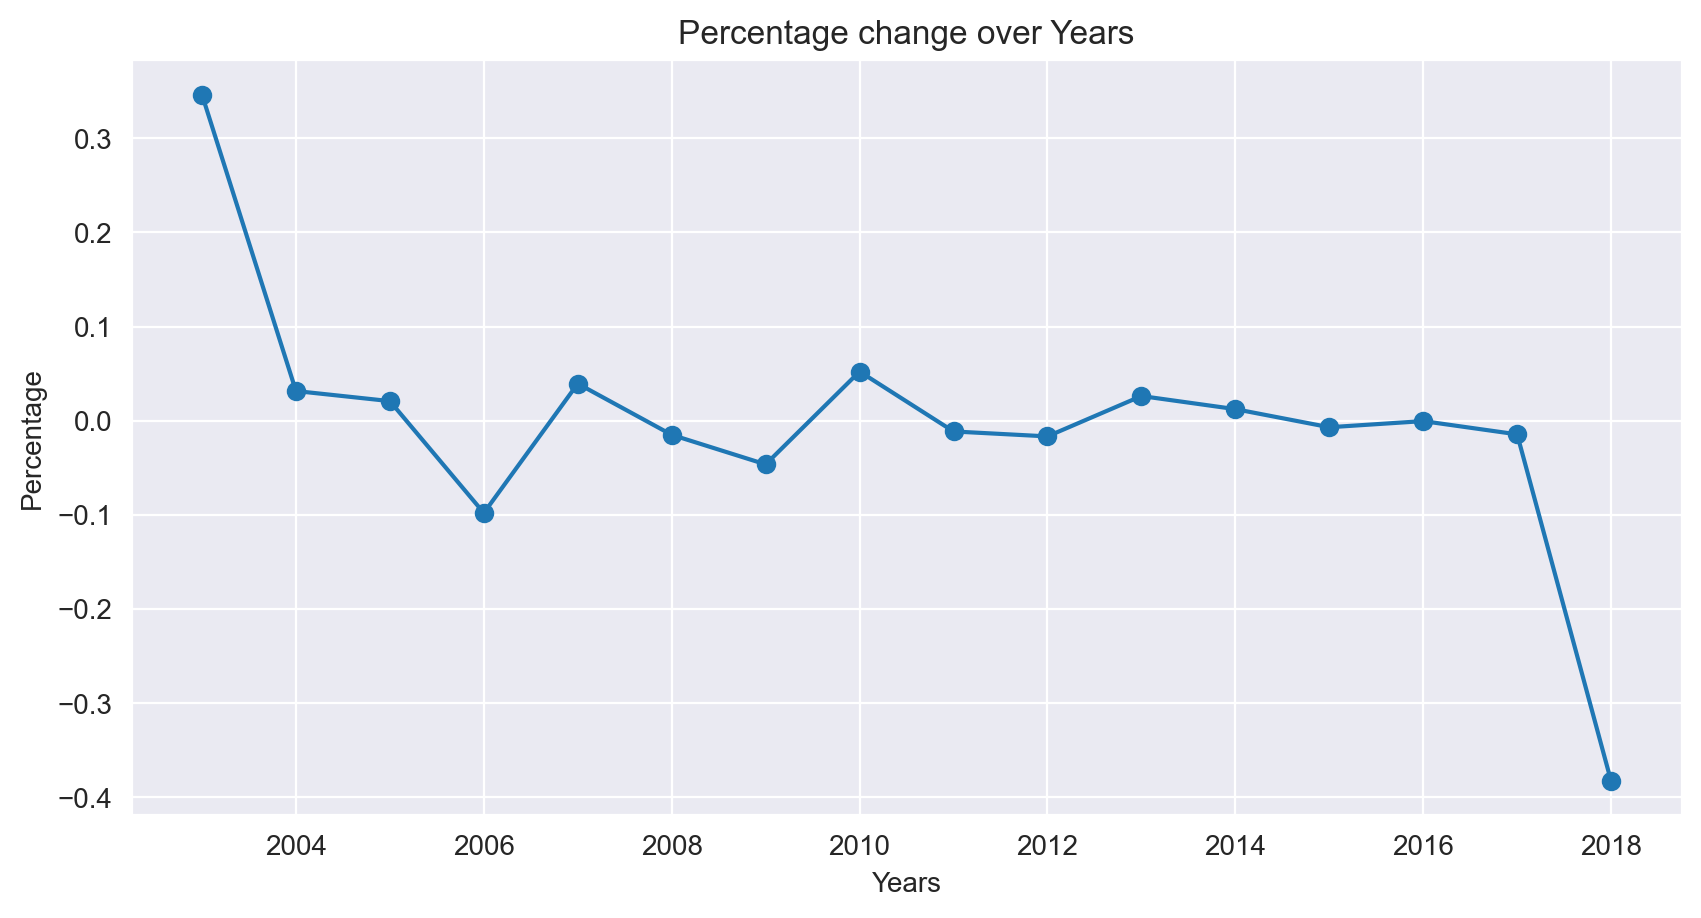

In [113]:
pct_change_year.plot(marker='o', title='Percentage change over Years')
plt.xlabel('Years')
plt.ylabel('Percentage')

In [114]:
# Percentage change of power usage per month
pct_change_month = df.groupby(df.index.month_name())["PJMW_MW"].sum().pct_change()
pct_change_month

Datetime
April             NaN
August       0.127221
December     0.040429
February    -0.057765
January      0.117759
July        -0.027998
June        -0.086114
March       -0.003397
May         -0.056089
November    -0.019102
October     -0.044456
September    0.008487
Name: PJMW_MW, dtype: float64

Text(0, 0.5, 'Percentage')

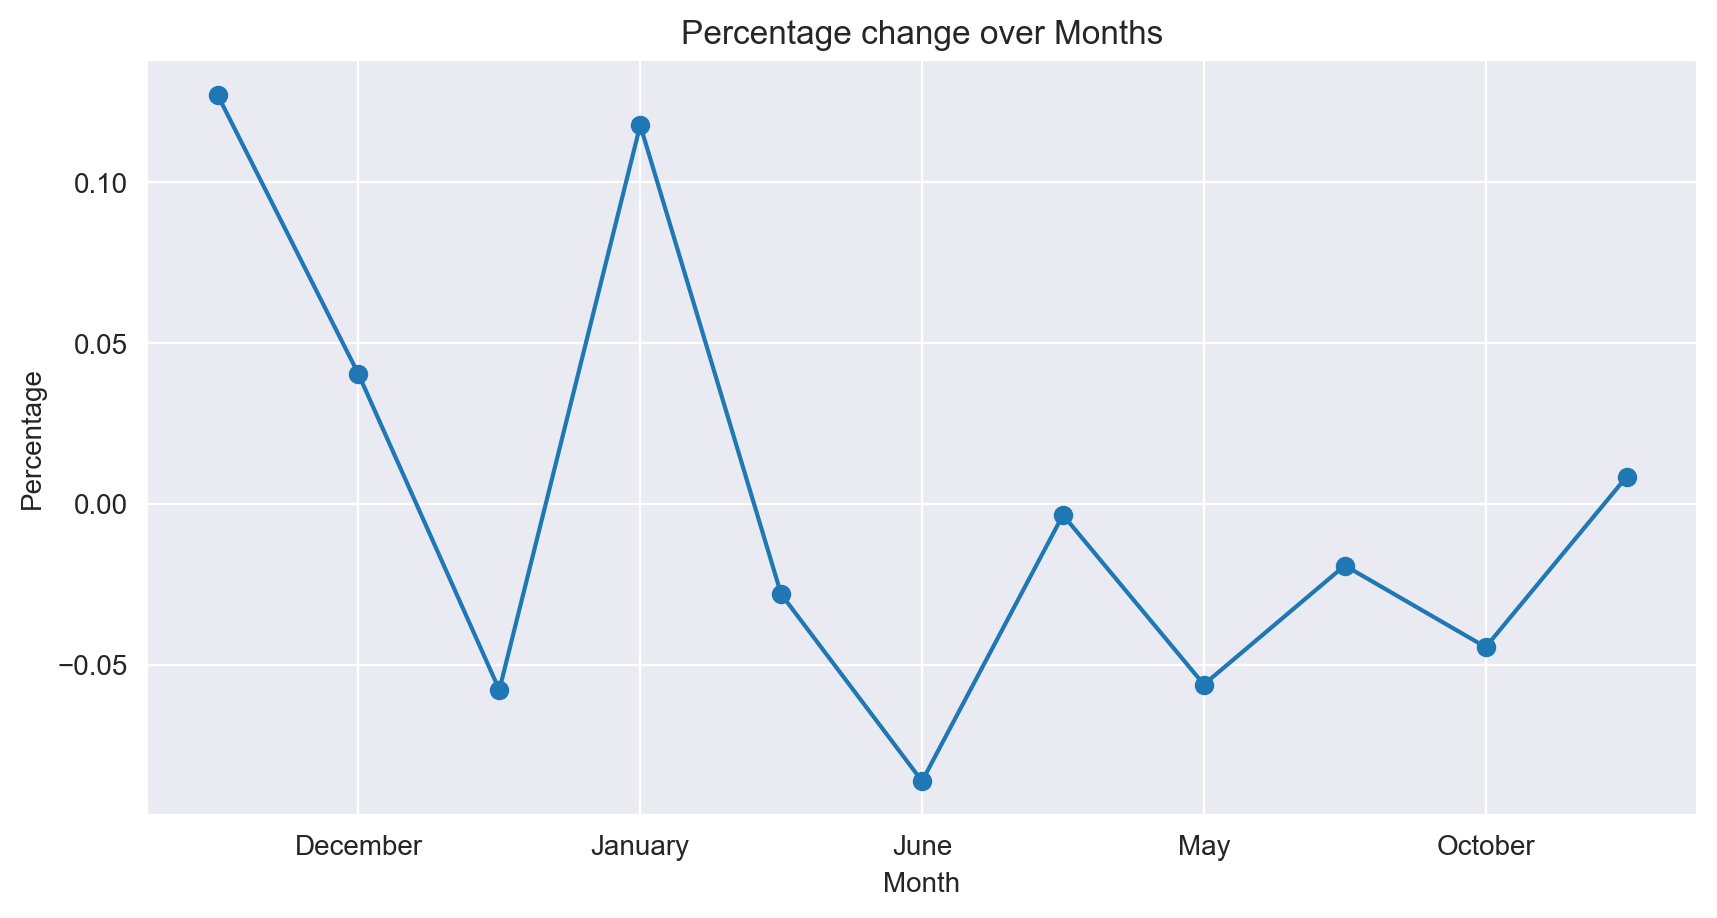

In [115]:
pct_change_month.plot(marker='o', title='Percentage change over Months')
plt.xlabel('Month')
plt.ylabel('Percentage')

### Decomposing the Time Series and plotting the different components

#### Assuming Additive Decomposition

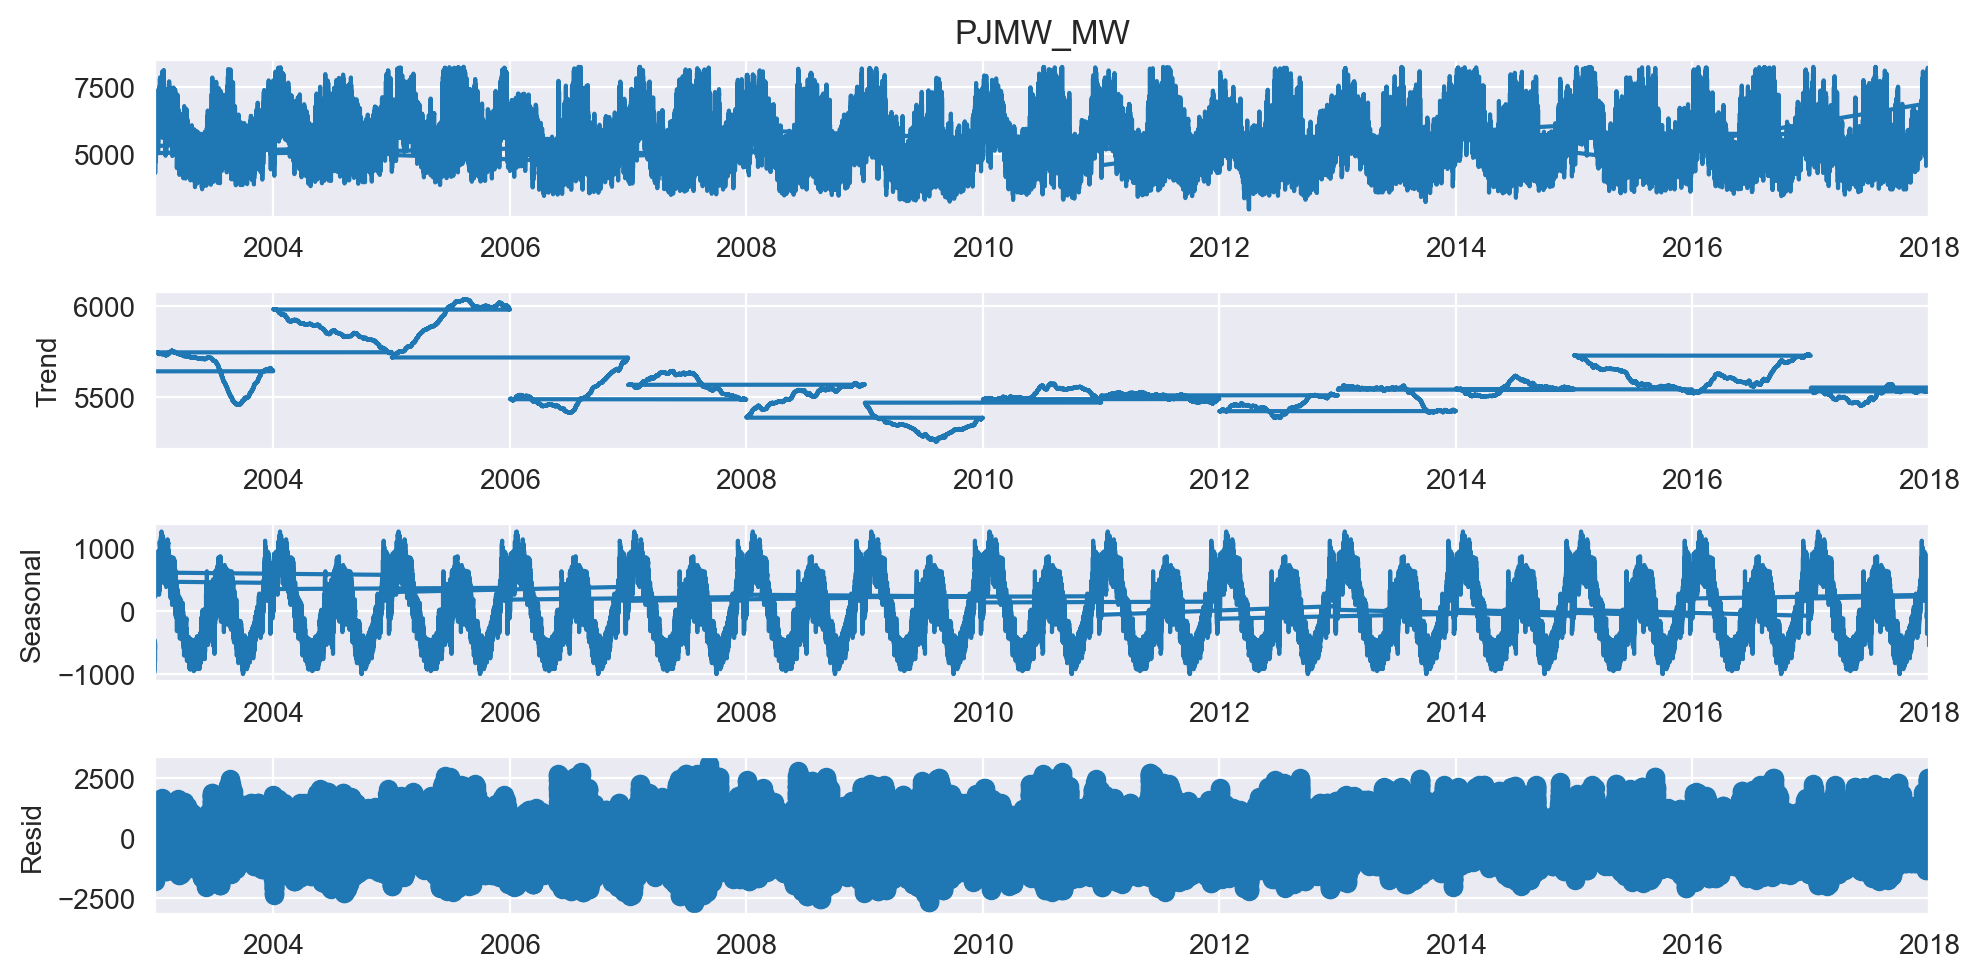

In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
add_decomposition = seasonal_decompose(df['PJMW_MW'], model='additive', period=8760)
add_decomposition.plot();

#### Assuming Multiplicative Decomposition

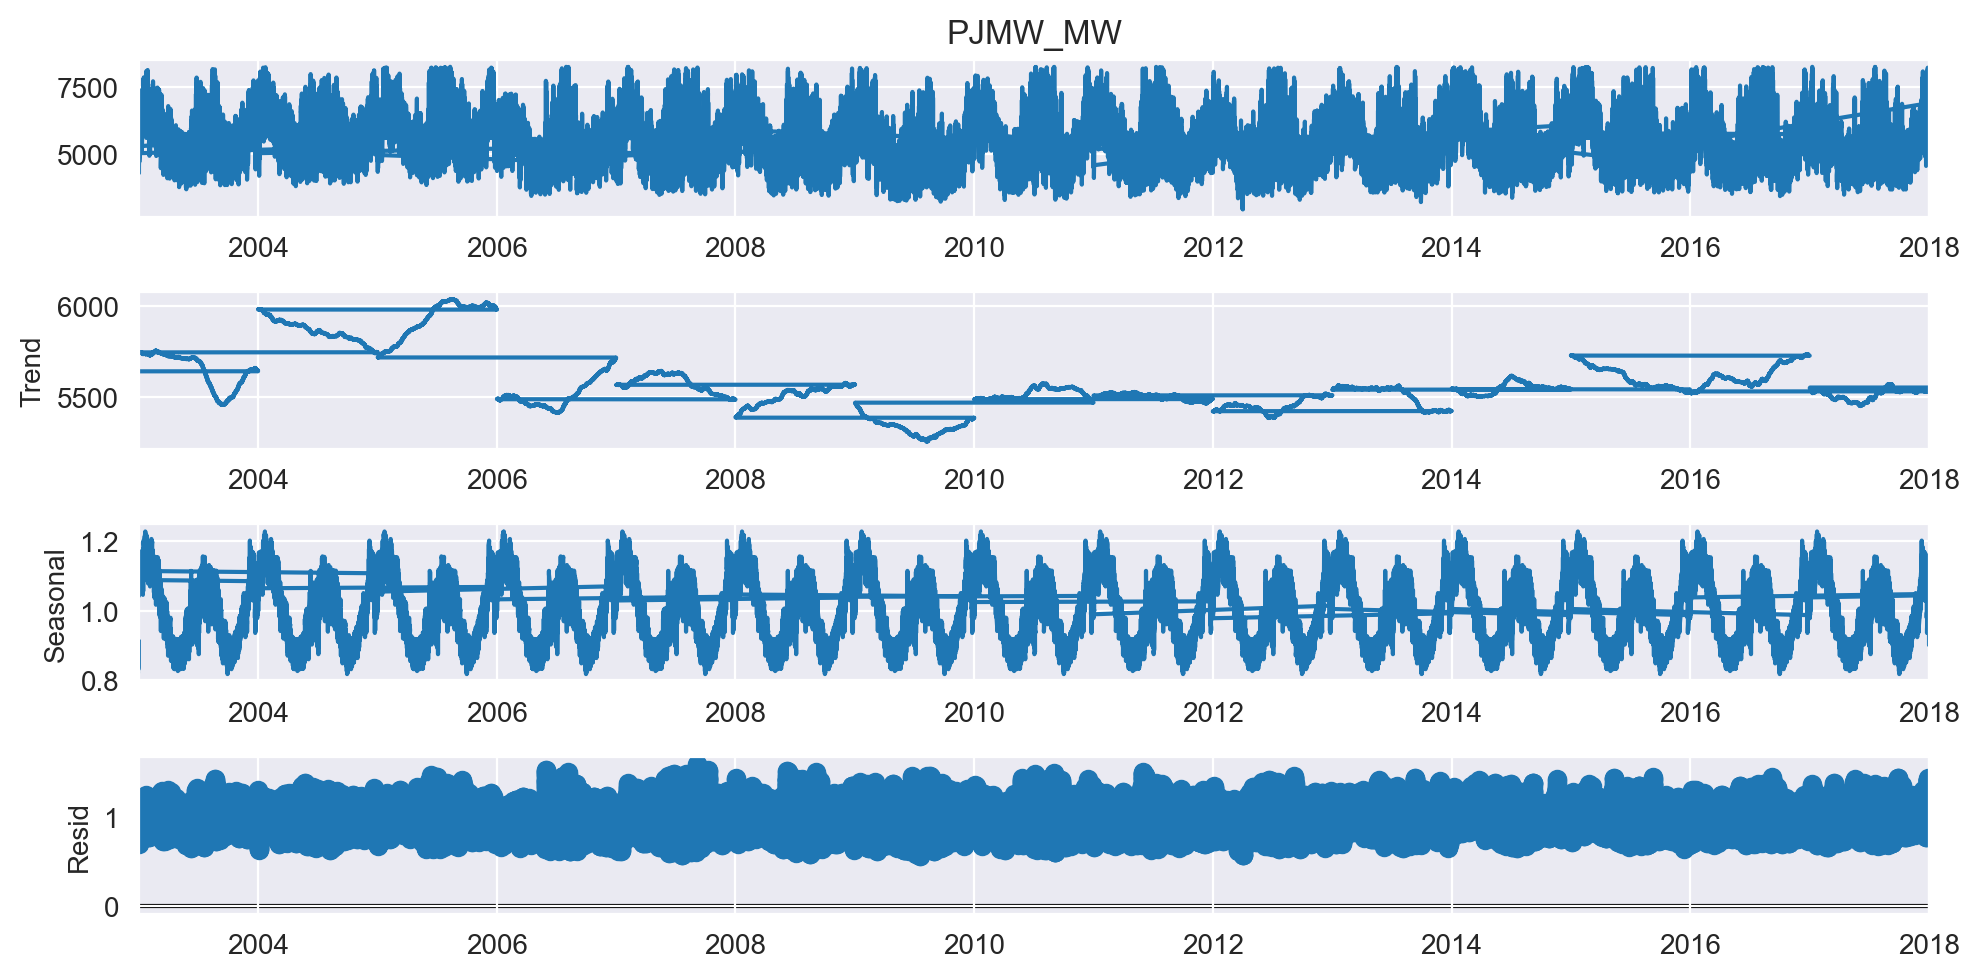

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose
mul_decomposition = seasonal_decompose(df['PJMW_MW'], model='multiplicative', period=8760)
mul_decomposition.plot();

#### In the multiplicative model, We observe that the trend and seasonality are clearly separated and the scale of noise is small. In the additive model, there are outliers present in the residual. So the series is multiplicative.

In [118]:
from statsmodels.tsa.stattools import adfuller

In [119]:
p = adfuller(df['PJMW_MW'])[1]
p

0.0

#### According the p-value, the dataset is stationary as the p value is less than alpha value (0.05).

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

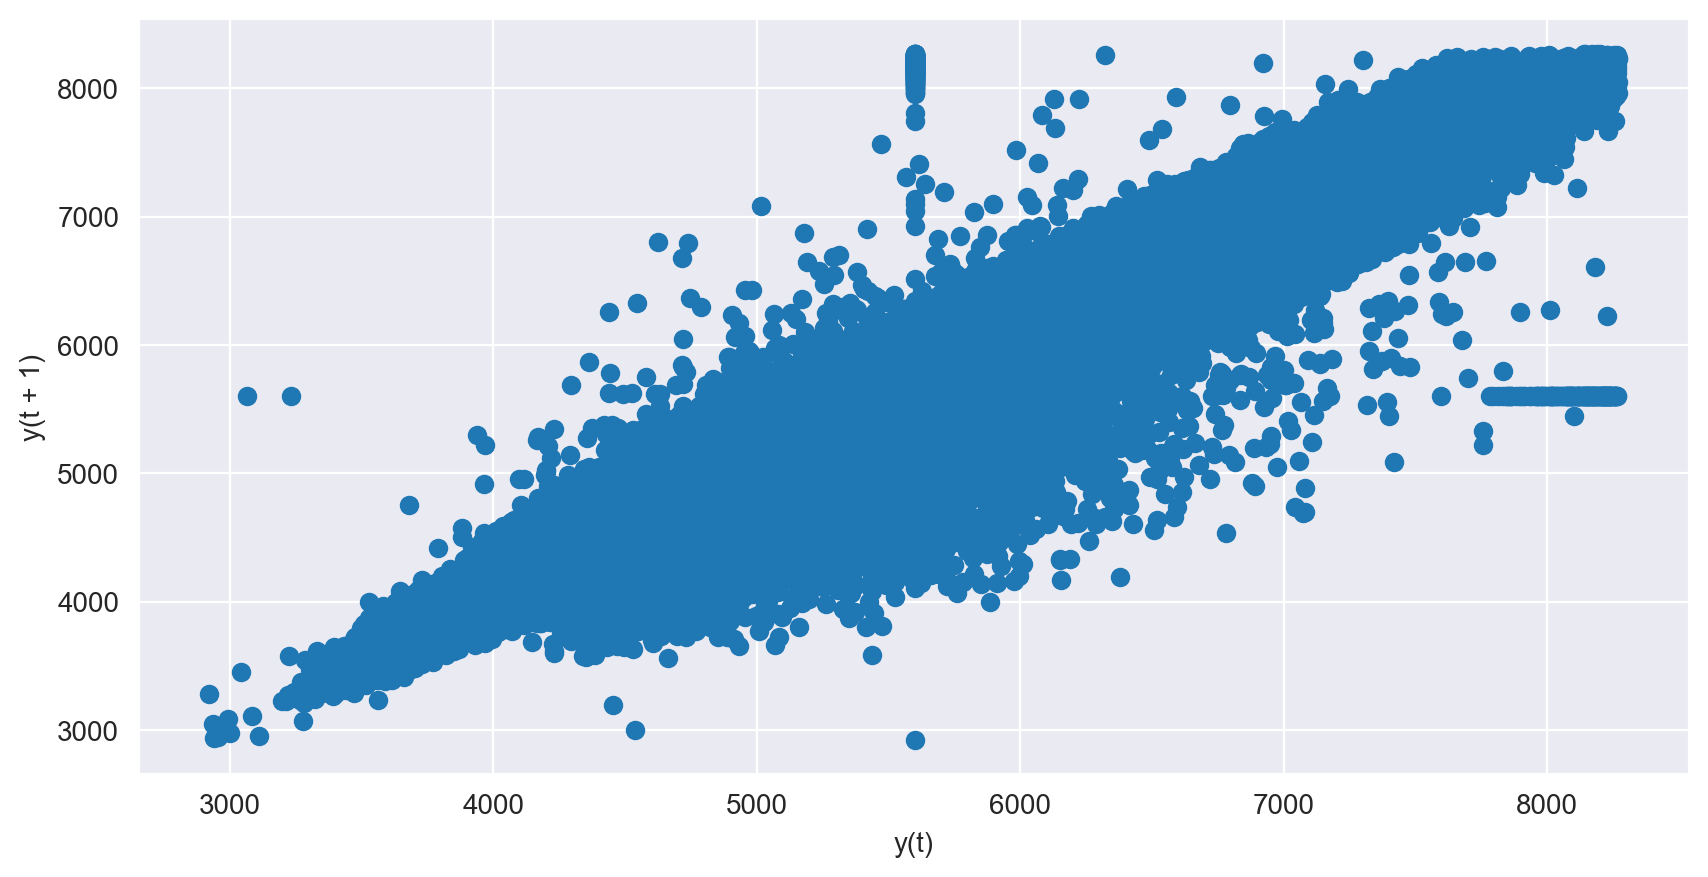

In [120]:
# Lag plot
pd.plotting.lag_plot(df['PJMW_MW'], lag=1)

In [121]:
# Original, moving average and std plot
df_ma = df['PJMW_MW'].rolling(window=8760).mean()
df_ma.dropna(inplace=True)
df_std = df['PJMW_MW'].rolling(window=8760).std()
df_std.dropna(inplace=True)

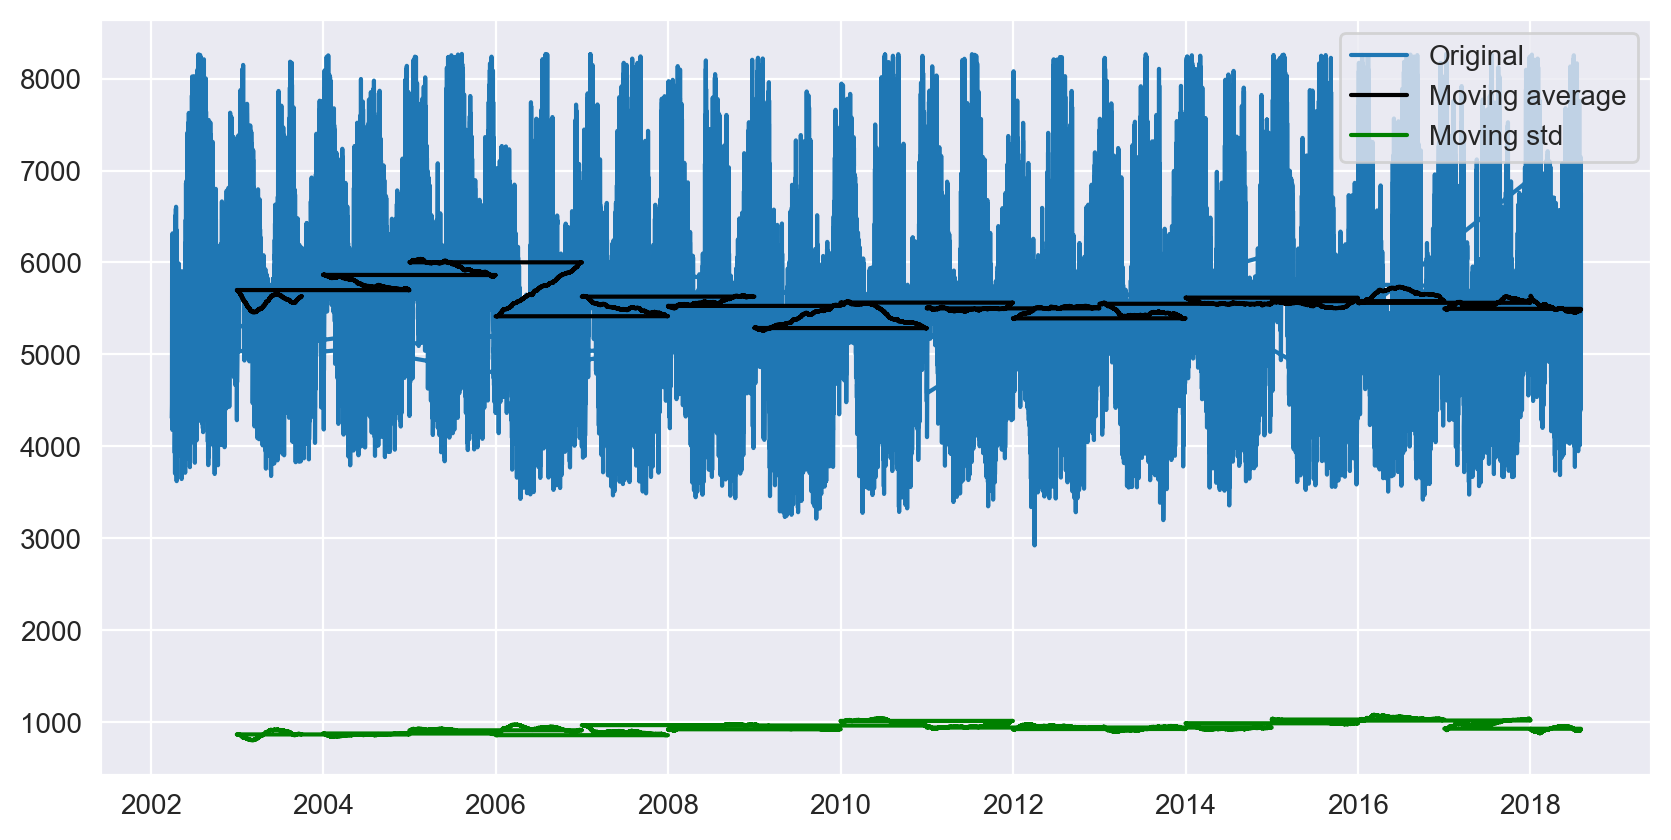

In [122]:
plt.plot(df['PJMW_MW'])
plt.plot(df_ma, color='black')
plt.plot(df_std, color='green')
plt.legend(labels=['Original', 'Moving average', 'Moving std'], loc='upper right')

In [123]:
df.shape

(143206, 4)

In [124]:
# Data for models
df['t'] = np.arange(1,143207)
df['t_square'] = np.square(df['t'])
df['log_PJMW'] = np.log(df['PJMW_MW'])
df

PJMW_MW  Years  Season  Hours       t   t_square  \
Datetime                                                                    
2002-12-31 01:00:00  5077.000000   2002  Winter      1       1          1   
2002-12-31 02:00:00  4939.000000   2002  Winter      2       2          4   
2002-12-31 03:00:00  4885.000000   2002  Winter      3       3          9   
2002-12-31 04:00:00  4857.000000   2002  Winter      4       4         16   
2002-12-31 05:00:00  4930.000000   2002  Winter      5       5         25   
...                          ...    ...     ...    ...     ...        ...   
2018-01-01 20:00:00  5602.375089   2018  Winter     20  143202 -968023676   
2018-01-01 21:00:00  5602.375089   2018  Winter     21  143203 -967737271   
2018-01-01 22:00:00  8238.000000   2018  Winter     22  143204 -967450864   
2018-01-01 23:00:00  7958.000000   2018  Winter     23  143205 -967164455   
2018-01-02 00:00:00  7691.000000   2018  Winter      0  143206 -966878044   

                     log_PJMW  
Datetime                       
2002-12-31 01:00:00  8.532476  
2002-12-31 02:00:00  8.504918  
2002-12-31 03:00:00  8.493925  
2002-12-31 04:00:00  8.488176  
2002-12-31 05:00:00  8.503094  
...                       ...  
2018-01-01 20:00:00  8.630946  
2018-01-01 21:00:00  8.630946  
2018-01-01 22:00:00  9.016513  
2018-01-01 23:00:00  8.981933  
2018-01-02 00:00:00  8.947806  

[143206 rows x 7 columns]

### Spliting of data

In [125]:
df[df['Years'] == 2018]

PJMW_MW  Years  Season  Hours       t    t_square  \
Datetime                                                                     
2018-01-01 00:00:00  7612.000000   2018  Winter      0  129335  -452326959   
2018-08-02 01:00:00  5100.000000   2018  Summer      1  138072  1884008000   
2018-08-02 02:00:00  4840.000000   2018  Summer      2  138073  1884284145   
2018-08-02 03:00:00  4745.000000   2018  Summer      3  138074  1884560292   
2018-08-02 04:00:00  4572.000000   2018  Summer      4  138075  1884836441   
...                          ...    ...     ...    ...     ...         ...   
2018-01-01 20:00:00  5602.375089   2018  Winter     20  143202  -968023676   
2018-01-01 21:00:00  5602.375089   2018  Winter     21  143203  -967737271   
2018-01-01 22:00:00  8238.000000   2018  Winter     22  143204  -967450864   
2018-01-01 23:00:00  7958.000000   2018  Winter     23  143205  -967164455   
2018-01-02 00:00:00  7691.000000   2018  Winter      0  143206  -966878044   

                     log_PJMW  
Datetime                       
2018-01-01 00:00:00  8.937481  
2018-08-02 01:00:00  8.536996  
2018-08-02 02:00:00  8.484670  
2018-08-02 03:00:00  8.464847  
2018-08-02 04:00:00  8.427706  
...                       ...  
2018-01-01 20:00:00  8.630946  
2018-01-01 21:00:00  8.630946  
2018-01-01 22:00:00  9.016513  
2018-01-01 23:00:00  8.981933  
2018-01-02 00:00:00  8.947806  

[5136 rows x 7 columns]

In [126]:
train = df[df['Years'] != 2018]
test = df[df['Years'] == 2018]

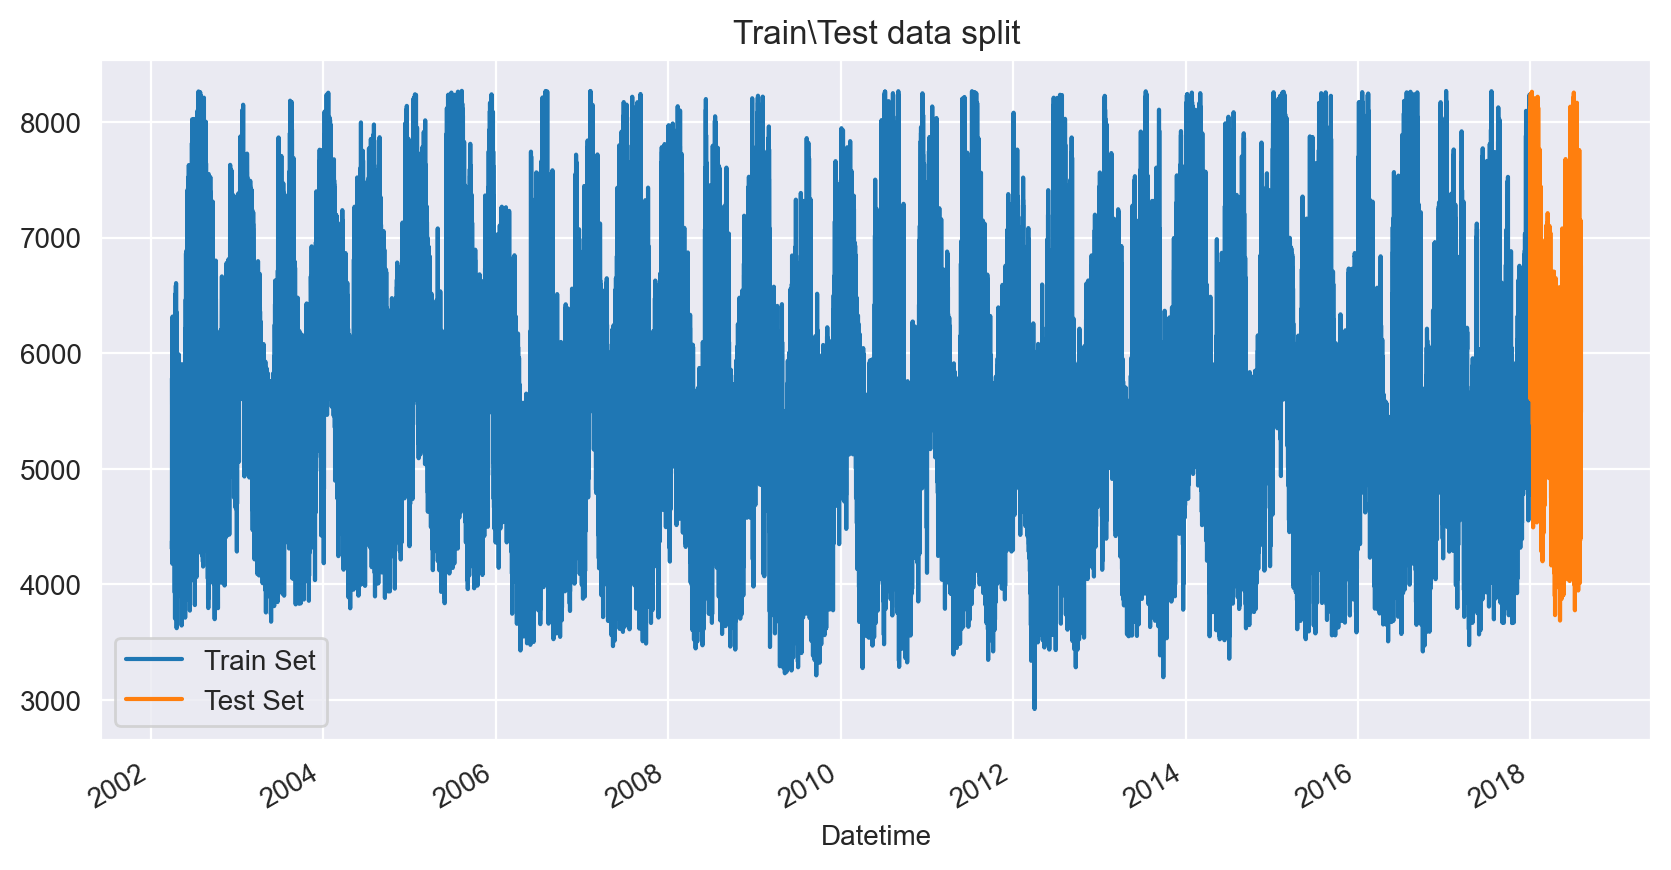

In [127]:
fig, ax = plt.subplots()
train['PJMW_MW'].plot(ax=ax, label='Train data', title='Train\Test data split')
test['PJMW_MW'].plot(ax=ax, label='Test data')
ax.legend(['Train Set', 'Test Set'])

# Model building

In [152]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

### Arima model

In [36]:
order = auto_arima(df['PJMW_MW'], start_p=1, start_q=1, test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [37]:
order

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

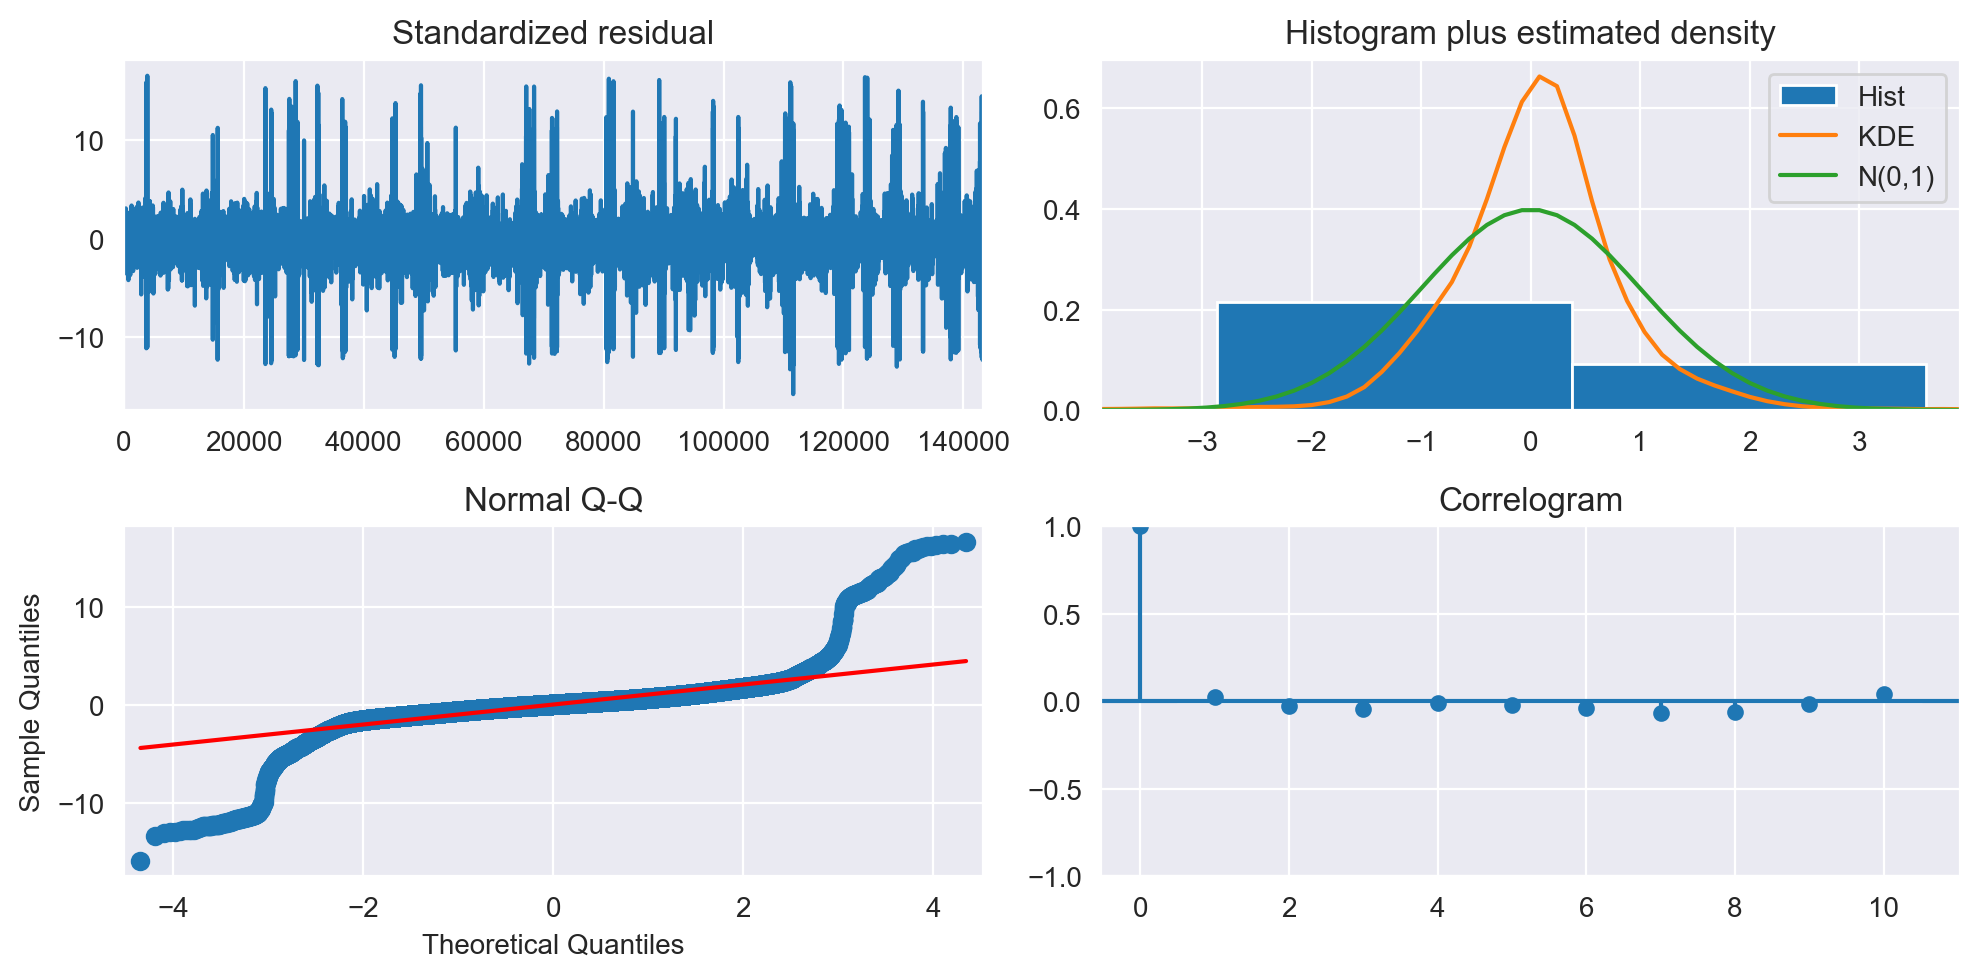

In [38]:
order.plot_diagnostics();
plt.tight_layout()

In [57]:
arima = ARIMA(train['PJMW_MW'], order=(3, 0, 2)).fit()
arima_pred = pd.Series(arima.predict(start=test.t[0], end=test.t[-1]))
rmse_arima = np.sqrt(mean_squared_error(test['PJMW_MW'], arima_pred))
rmse_arima

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-

1051.295352135866

### Sarima model

In [70]:
# Seasonal - fit stepwise auto-ARIMA
order1 = auto_arima(df['PJMW_MW'], start_p=1, start_q=1, test='adf', max_p=3, max_q=3, 
                         m=1, #1 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [71]:
order1

ARIMA(order=(3, 0, 3), scoring_args={}, suppress_warnings=True)

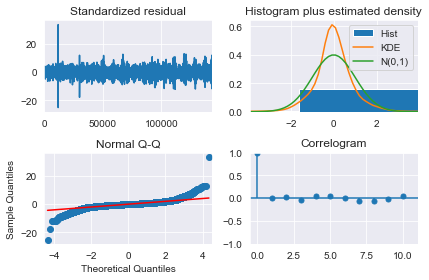

In [72]:
order1.plot_diagnostics();
plt.tight_layout()

In [162]:
sarima = ARIMA(train['PJMW_MW'], order=(3, 0, 3)).fit()
sarima_pred = pd.Series(sarima.predict(start=test.t[0], end=test.t[-1]))
rmse_sarima = np.sqrt(mean_squared_error(test['PJMW_MW'], sarima_pred))
rmse_sarima

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-

1046.8603529645818

### Model based Forecasting Methods

In [60]:
df.head(2)

PJMW_MW  Years  Season  Hours  t  t_square  log_PJMW
Datetime                                                                 
2002-12-31 01:00:00   5077.0   2002  Winter      1  1         1  8.532476
2002-12-31 02:00:00   4939.0   2002  Winter      2  2         4  8.504918

#### Linear model

In [61]:
linear = smf.ols('PJMW_MW~t', data=train).fit()
pred_linear = pd.Series(linear.predict((test[['t']])))
rmse_linear = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_linear))
rmse_linear

1077.6063180481474

#### Exponential model

In [62]:
exp = smf.ols('log_PJMW~t', data=train).fit()
pred_exp = pd.Series(exp.predict(test[['t']]))
rmse_exp = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_exp))
rmse_exp

5926.915942263731

#### Quadratic model

In [63]:
quad = smf.ols('PJMW_MW~t+t_square',data=train).fit()
pred_quad = pd.Series(quad.predict(test[['t', 't_square']]))
rmse_quad = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_quad))
rmse_quad

1081.98019462208

In [64]:
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing, ExponentialSmoothing

In [65]:
test

PJMW_MW  Years  Season  Hours       t    t_square  \
Datetime                                                                 
2018-08-02 01:00:00   5100.0   2018  Summer      1  138072  1884008000   
2018-08-02 02:00:00   4840.0   2018  Summer      2  138073  1884284145   
2018-08-02 03:00:00   4745.0   2018  Summer      3  138074  1884560292   
2018-08-02 04:00:00   4572.0   2018  Summer      4  138075  1884836441   
2018-08-02 05:00:00   4594.0   2018  Summer      5  138076  1885112592   
...                      ...    ...     ...    ...     ...         ...   
2018-01-01 20:00:00   8401.0   2018  Winter     20  143202  -968023676   
2018-01-01 21:00:00   8373.0   2018  Winter     21  143203  -967737271   
2018-01-01 22:00:00   8238.0   2018  Winter     22  143204  -967450864   
2018-01-01 23:00:00   7958.0   2018  Winter     23  143205  -967164455   
2018-01-02 00:00:00   7691.0   2018  Winter      0  143206  -966878044   

                     log_PJMW  
Datetime                       
2018-08-02 01:00:00  8.536996  
2018-08-02 02:00:00  8.484670  
2018-08-02 03:00:00  8.464847  
2018-08-02 04:00:00  8.427706  
2018-08-02 05:00:00  8.432506  
...                       ...  
2018-01-01 20:00:00  9.036106  
2018-01-01 21:00:00  9.032768  
2018-01-01 22:00:00  9.016513  
2018-01-01 23:00:00  8.981933  
2018-01-02 00:00:00  8.947806  

[5135 rows x 7 columns]

### Simple Exponential Method

In [66]:
ses_model = SimpleExpSmoothing(train['PJMW_MW']).fit()
pred_ses = ses_model.predict(start=test.t[0], end=test.t[-1])
rmse_ses = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_ses))
rmse_ses

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1308.8354630701072

### Holt method

In [67]:
holt_model = Holt(train['PJMW_MW']).fit()
pred_holt = holt_model.predict(start=test.t[0], end=test.t[-1])
rmse_holt = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_holt))
rmse_holt

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


805011.6442961129

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [68]:
holt_mul_sea_add_tr = ExponentialSmoothing(train["PJMW_MW"],seasonal="mul",trend="add", seasonal_periods=365).fit()
pred_holt_mul_sea_add_tr = holt_mul_sea_add_tr.predict(start=test.t[0], end=test.t[-1])
rmse_holt_mul_sea_add_tr = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_holt_mul_sea_add_tr))
rmse_holt_mul_sea_add_tr

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


544187.7371805651

### Holts winter exponential smoothing with additive seasonality and additive trend

In [69]:
holt_add_sea_add_tr = ExponentialSmoothing(train["PJMW_MW"],seasonal="add",trend="add", seasonal_periods=365).fit()
pred_holt_add_sea_add_tr = holt_add_sea_add_tr.predict(start=test.t[0], end=test.t[-1])
rmse_holt_add_sea_add_tr = np.sqrt(mean_squared_error(test['PJMW_MW'], pred_holt_add_sea_add_tr))
rmse_holt_add_sea_add_tr

C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rohit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


489601.8149423828

### XGBRegressor model

In [138]:
from xgboost import XGBRegressor, plot_importance, plot_tree

In [128]:
df.head(2)

PJMW_MW  Years  Season  Hours  t  t_square  log_PJMW
Datetime                                                                 
2002-12-31 01:00:00   5077.0   2002  Winter      1  1         1  8.532476
2002-12-31 02:00:00   4939.0   2002  Winter      2  2         4  8.504918

In [143]:
df_2 = df.drop(columns=['Years', 'Season', 'Hours', 't', 't_square', 'log_PJMW'])
df_2['hour'] = df_2.index.hour
df_2['dayofweek'] = df_2.index.dayofweek
df_2['quarter'] = df_2.index.quarter
df_2['month'] = df_2.index.month
df_2['year'] = df_2.index.year
df_2['dayofyear'] = df_2.index.dayofyear
df_2['dayofmonth'] = df_2.index.day
df_2

PJMW_MW  hour  dayofweek  quarter  month  year  \
Datetime                                                                  
2002-12-31 01:00:00  5077.000000     1          1        4     12  2002   
2002-12-31 02:00:00  4939.000000     2          1        4     12  2002   
2002-12-31 03:00:00  4885.000000     3          1        4     12  2002   
2002-12-31 04:00:00  4857.000000     4          1        4     12  2002   
2002-12-31 05:00:00  4930.000000     5          1        4     12  2002   
...                          ...   ...        ...      ...    ...   ...   
2018-01-01 20:00:00  5602.375089    20          0        1      1  2018   
2018-01-01 21:00:00  5602.375089    21          0        1      1  2018   
2018-01-01 22:00:00  8238.000000    22          0        1      1  2018   
2018-01-01 23:00:00  7958.000000    23          0        1      1  2018   
2018-01-02 00:00:00  7691.000000     0          1        1      1  2018   

                     dayofyear  dayofmonth  
Datetime                                    
2002-12-31 01:00:00        365          31  
2002-12-31 02:00:00        365          31  
2002-12-31 03:00:00        365          31  
2002-12-31 04:00:00        365          31  
2002-12-31 05:00:00        365          31  
...                        ...         ...  
2018-01-01 20:00:00          1           1  
2018-01-01 21:00:00          1           1  
2018-01-01 22:00:00          1           1  
2018-01-01 23:00:00          1           1  
2018-01-02 00:00:00          2           2  

[143206 rows x 8 columns]

In [144]:
train_data = df_2[df_2['year'] != 2018]
test_data = df_2[df_2['year'] == 2018]

In [146]:
x_train = train_data[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
x_test = test_data[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
y_train = train_data[['PJMW_MW']]
y_test = test_data[['PJMW_MW']]

In [149]:
xgb_model = XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03, max_depth= 5, min_child_weight= 4, 
                        n_estimators= 500, nthread= 4, objective= 'reg:linear', subsample= 0.7)
xgb_model.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)], early_stopping_rounds=50, verbose=False)

[15:13:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:linear', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

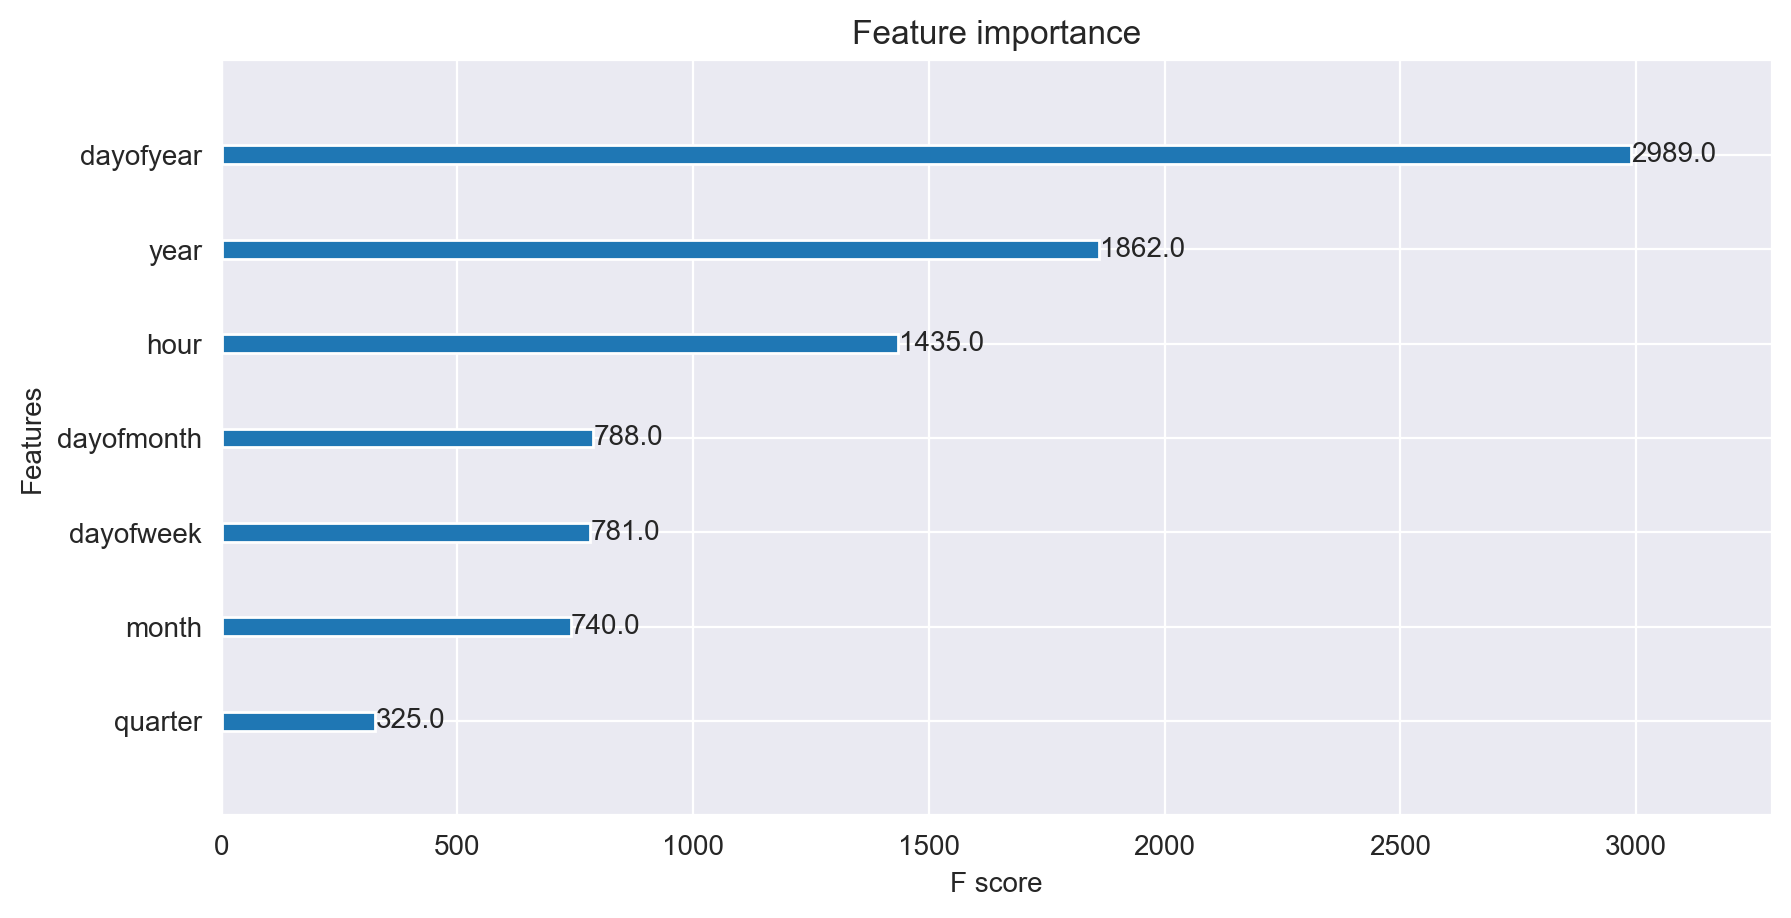

In [150]:
plot_importance(xgb_model)

In [159]:
# Prediction on train data
pred_xgb1 = xgb_model.predict(x_train)
rmse_xgb1 = np.sqrt(mean_squared_error(y_train, pred_xgb1))
rmse_xgb1

453.535091855716

In [154]:
# Prediction on test data
pred_xgb = xgb_model.predict(x_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
rmse_xgb

658.0785097288343

In [174]:
# Prediction on entire data
pred_xgb2 = xgb_model.predict(df_2.iloc[:,1:])
rmse_xgb2 = np.sqrt(mean_squared_error(df_2['PJMW_MW'], pred_xgb2))
rmse_xgb2

462.4377676054712

### Model - RMSE value data

In [77]:
data = {
    'Model' : ['Linear model', 'Exponential model', 'Quadratic model', 'Arima model', 'Sarima model',
               'Simple Exponential Method', 'Holt model', 
               'Holts winter exponential smoothing model with multiplicative seasonality and additive trend', 
               'Holts winter exponential smoothing model with additive seasonality and additive trend', 'XGBoost'],
    'RMSE Values' : [rmse_linear, rmse_exp, rmse_quad, rmse_arima, rmse_sarima, rmse_ses, rmse_holt, 
                     rmse_holt_mul_sea_add_tr, rmse_holt_add_sea_add_tr, rmse_xgb]
}
RMSE = pd.DataFrame(data)
RMSE

Model    RMSE Values
0                                       Linear model    1077.606318
1                                  Exponential model    5926.915942
2                                    Quadratic model    1081.980195
3                                        Arima model    1051.295352
4                                       Sarima model    1046.860353
5                          Simple Exponential Method    1308.835463
6                                         Holt model  805011.644296
7  Holts winter exponential smoothing model with ...  544187.737181
8  Holts winter exponential smoothing model with ...  489601.814942

In [182]:
final_pred = xgb_model.predict(df_2.iloc[:,1:])
final_pred = pd.DataFrame(final_pred, columns=['Predicted'], index=df.index)
final_pred

Predicted
Datetime                        
2002-12-31 01:00:00  5422.207520
2002-12-31 02:00:00  5320.763672
2002-12-31 03:00:00  5303.714355
2002-12-31 04:00:00  5302.856934
2002-12-31 05:00:00  5325.945312
...                          ...
2018-01-01 20:00:00  6033.347656
2018-01-01 21:00:00  6033.347656
2018-01-01 22:00:00  5863.023926
2018-01-01 23:00:00  5566.101074
2018-01-02 00:00:00  5525.867188

[143206 rows x 1 columns]

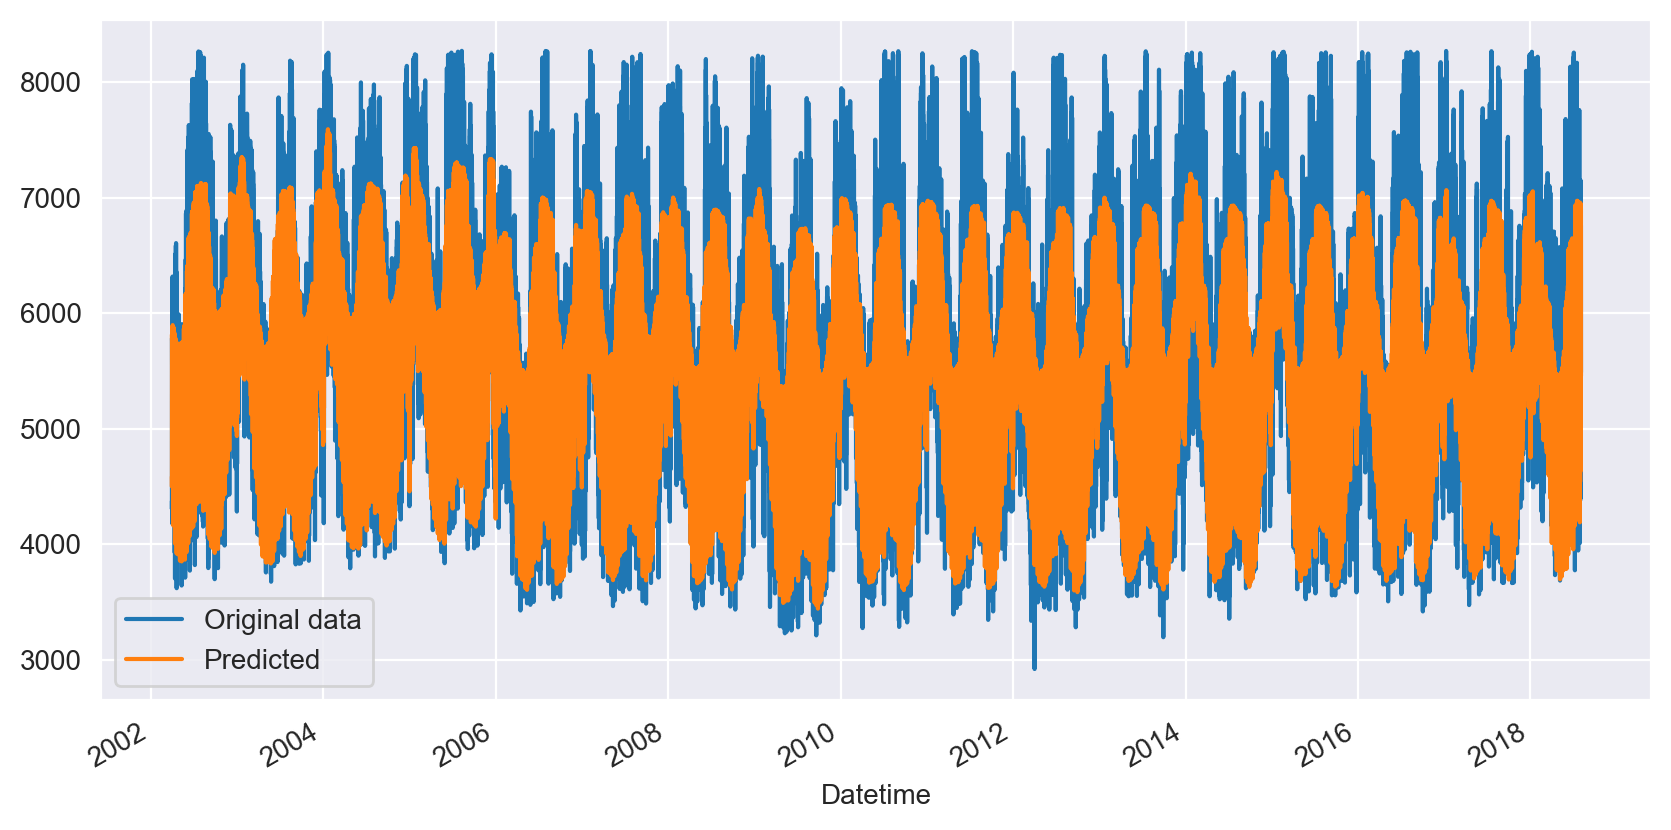

In [191]:
fig, ax = plt.subplots()
df['PJMW_MW'].plot(ax=ax, label='Original data')
final_pred.plot(ax=ax, label='Predicted')
plt.legend(['Original data', 'Predicted'])

# Forecast for next 30 days

In [185]:
from datetime import datetime
datetime_str = '08/03/18 00:00:00'
datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')
print(datetime_object)

2018-08-03 00:00:00


In [186]:
index_of_forecast = pd.date_range(datetime_object + pd.DateOffset(days=1), periods = 30*24, freq='H')
index_of_forecast

DatetimeIndex(['2018-08-04 00:00:00', '2018-08-04 01:00:00',
               '2018-08-04 02:00:00', '2018-08-04 03:00:00',
               '2018-08-04 04:00:00', '2018-08-04 05:00:00',
               '2018-08-04 06:00:00', '2018-08-04 07:00:00',
               '2018-08-04 08:00:00', '2018-08-04 09:00:00',
               ...
               '2018-09-02 14:00:00', '2018-09-02 15:00:00',
               '2018-09-02 16:00:00', '2018-09-02 17:00:00',
               '2018-09-02 18:00:00', '2018-09-02 19:00:00',
               '2018-09-02 20:00:00', '2018-09-02 21:00:00',
               '2018-09-02 22:00:00', '2018-09-02 23:00:00'],
              dtype='datetime64[ns]', length=720, freq='H')

In [189]:
fut_in = pd.DataFrame(index=index_of_forecast)
fut_in['hour'] = fut_in.index.hour
fut_in['dayofweek'] = fut_in.index.dayofweek
fut_in['quarter'] = fut_in.index.quarter
fut_in['month'] = fut_in.index.month
fut_in['year'] = fut_in.index.year
fut_in['dayofyear'] = fut_in.index.dayofyear
fut_in['dayofmonth'] = fut_in.index.day
fut_in

hour  dayofweek  quarter  month  year  dayofyear  \
2018-08-04 00:00:00     0          5        3      8  2018        216   
2018-08-04 01:00:00     1          5        3      8  2018        216   
2018-08-04 02:00:00     2          5        3      8  2018        216   
2018-08-04 03:00:00     3          5        3      8  2018        216   
2018-08-04 04:00:00     4          5        3      8  2018        216   
...                   ...        ...      ...    ...   ...        ...   
2018-09-02 19:00:00    19          6        3      9  2018        245   
2018-09-02 20:00:00    20          6        3      9  2018        245   
2018-09-02 21:00:00    21          6        3      9  2018        245   
2018-09-02 22:00:00    22          6        3      9  2018        245   
2018-09-02 23:00:00    23          6        3      9  2018        245   

                     dayofmonth  
2018-08-04 00:00:00           4  
2018-08-04 01:00:00           4  
2018-08-04 02:00:00           4  
2018-08-04 03:00:00           4  
2018-08-04 04:00:00           4  
...                         ...  
2018-09-02 19:00:00           2  
2018-09-02 20:00:00           2  
2018-09-02 21:00:00           2  
2018-09-02 22:00:00           2  
2018-09-02 23:00:00           2  

[720 rows x 7 columns]

In [190]:
forecast = xgb_model.predict(fut_in)
forecast = pd.DataFrame(forecast, columns=['Forecast'], index=fut_in.index)
forecast

Forecast
2018-08-04 00:00:00  5223.361328
2018-08-04 01:00:00  4822.217773
2018-08-04 02:00:00  4518.302246
2018-08-04 03:00:00  4365.653809
2018-08-04 04:00:00  4355.415039
...                          ...
2018-09-02 19:00:00  5752.320801
2018-09-02 20:00:00  5668.839844
2018-09-02 21:00:00  5649.930664
2018-09-02 22:00:00  5494.070801
2018-09-02 23:00:00  5144.614258

[720 rows x 1 columns]

<Axes: >

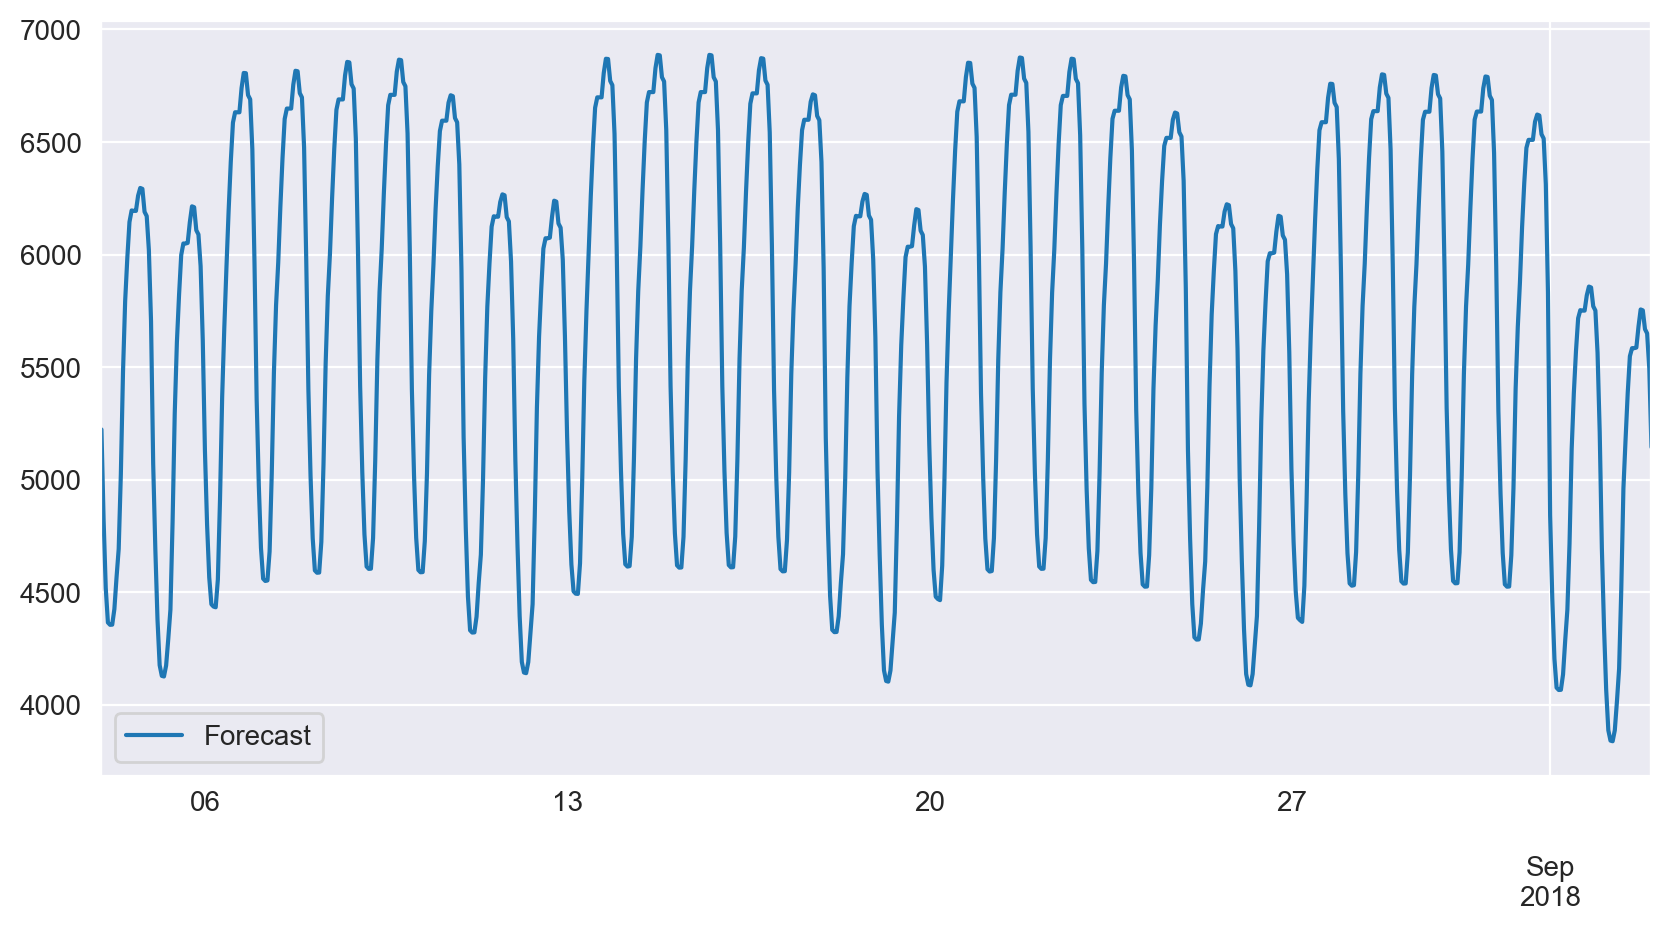

In [193]:
forecast.plot()

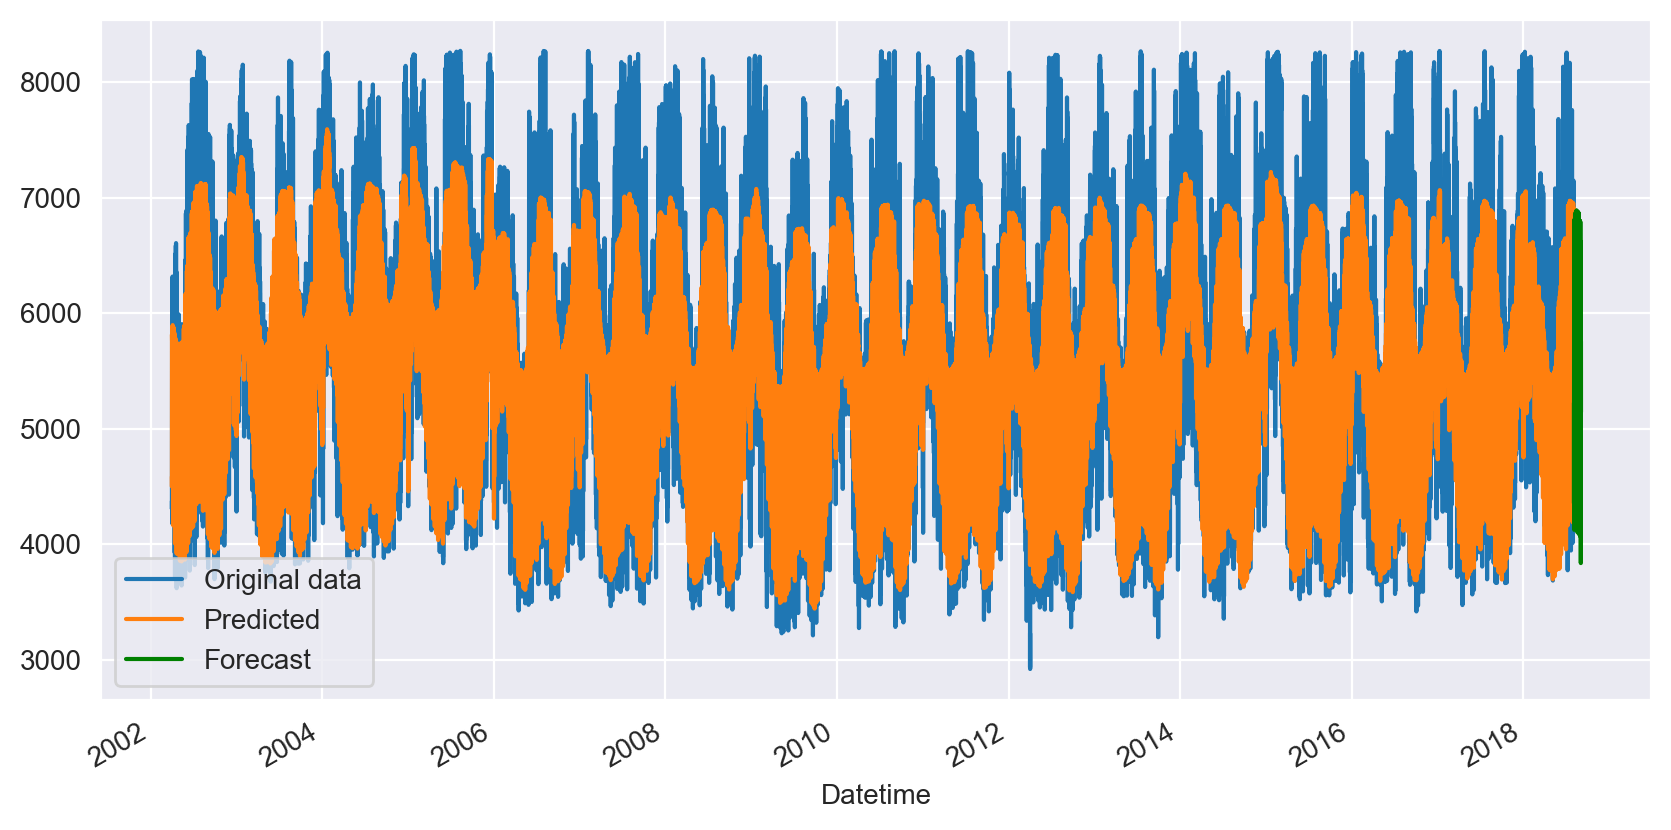

In [194]:
fig, ax = plt.subplots()
df['PJMW_MW'].plot(ax=ax, label='Original data')
final_pred.plot(ax=ax, label='Predicted')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Predicted', 'Forecast'])

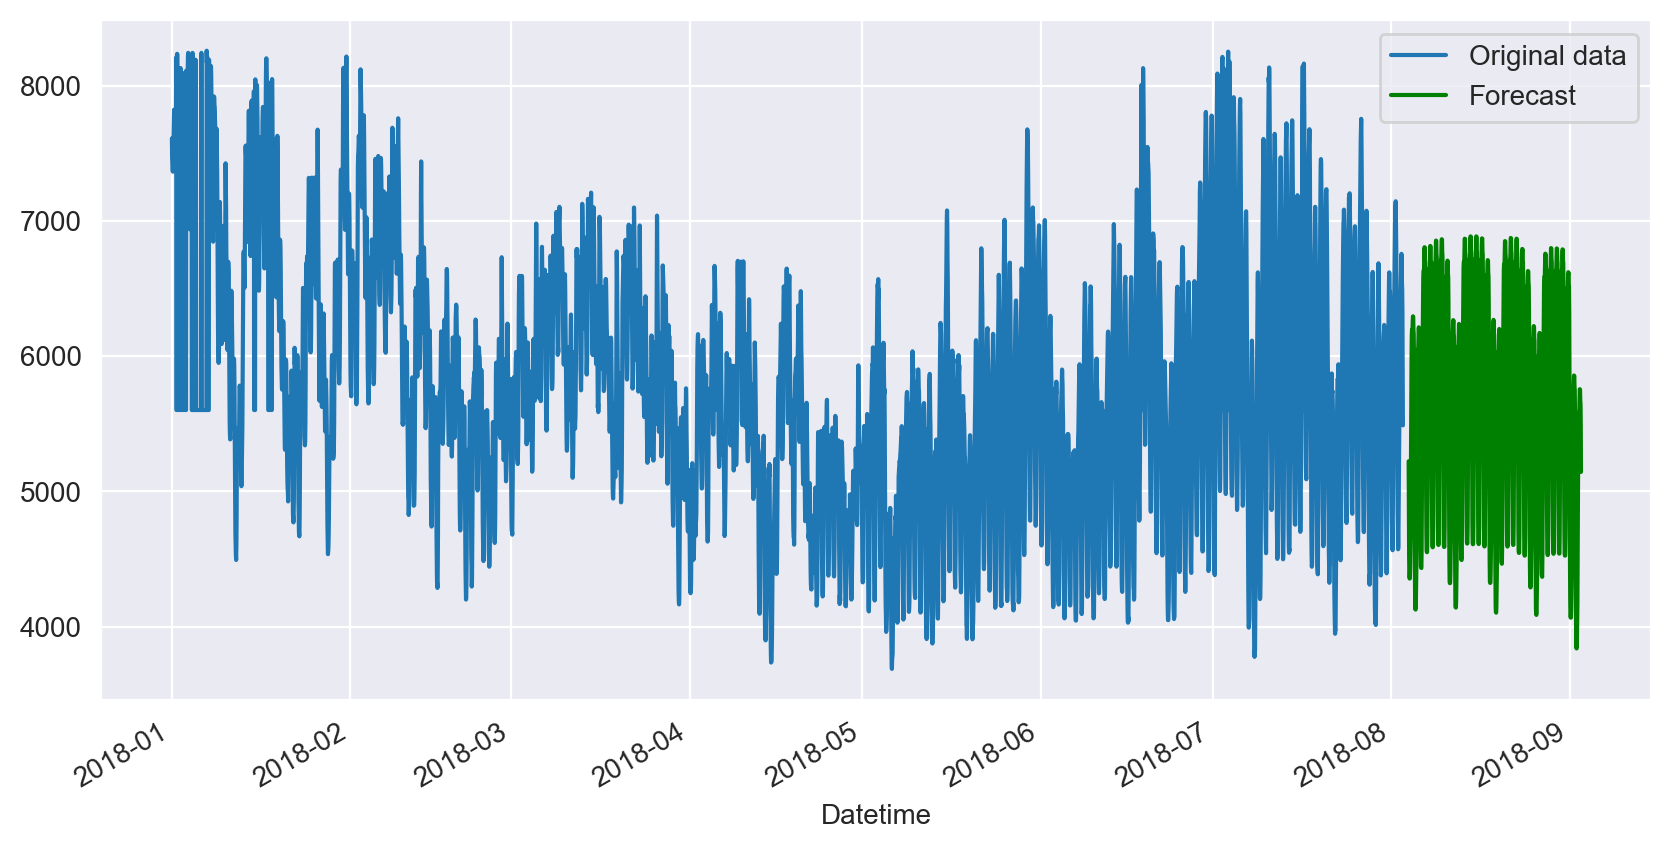

In [195]:
fig, ax = plt.subplots()
y_test['PJMW_MW'].plot(ax=ax, label='Original data')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Forecast'])